# [Basic implementation of MRI signal](#title)
This notebook implements simple versions of the most common DCE-MRI sequences. It assumes ideal conditions and later on will be adding realistic constraints. The final aim is to create a synthetic image that can be used for testing DCE-MRI analysis software. 
The code in here is based on the matlab implementation of a [DCE Digital Reference Object](https://github.com/anstepsa/dce-dro-matlab)

## [Import relevant modules](#python-modules)

In [3]:
import os
import cv2
import json
import datetime
import numpy as np
import pandas as pd
import pydicom as pyd
import nibabel as nib
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters

# If the background colour of the plots is the same as the VS theme, check the option jupyter.themeMatplotlibPlots, 
# as indicated at https://stackoverflow.com/questions/75154449/vscode-setup-question-python-plot-background-color
# --> In macOS, go to Code -> Settings -> Settings -> Users -> jupyter:themeMatplotlibPlots

# Additional PyDicom tools
from pydicom.dataset import Dataset, FileMetaDataset



## [Auxiliar Functions](#auxiliar-functions)

In [4]:
def M0(k, rho):
    
    return k*rho

def relaxationTerm(acquisitionTpar, relaxationTime):

    expTacqRelT = np.exp(- acquisitionTpar / (relaxationTime + 1e-9))
    expTacqRelT *= (relaxationTime > 0.0)
    return expTacqRelT

def E1(TR, T1):
    
    return relaxationTerm(TR,T1)

def E2(TE, T2star):
    
    return relaxationTerm(TE,T2star)


### [T1W sequences - SPGR & IR](#t1w-functions)

In [5]:
def spgr_signal(s0, t1, tr, flip_angle, te, t2star):
    
    fa_radians = np.deg2rad(flip_angle)
    t2contrib = E2(TE=te, T2star=t2star)
    t1contrib = E1(TR=tr, T1=t1)
    
    num = (1 - t1contrib) 
    den = (1-np.cos(fa_radians)*t1contrib)
    scaling_factor = s0*np.sin(fa_radians)
    s = scaling_factor * t2contrib * num / den

    return s

# Define cost functions to estimate T1 with SPGR and IR
def fit_SPGR_t1(params, flip_angle, values):
    s0 = params['s0'].value
    t1 = params['t1'].value
    tr = params['tr'].value
    te = params['te'].value
    t2star = params['t2star'].value

    s = spgr_signal(s0, t1, tr, flip_angle, te, t2star)
    return (np.fabs(s) - np.fabs(values))

# Define the optimisation method
def do_spgr_fit(ydata, fa, tr, te, t2star, initial_s0=1.0, initial_t1=1000.0):
    params = Parameters()
    params.add('s0', value=initial_s0, vary=True)
    params.add('t1', value=initial_t1, vary=True, min=0.0, max=10000.0)
    params.add('tr', value=tr, vary=False)
    params.add('te', value=te, vary=False)
    params.add('t2star', value=t2star, vary=False)
    
    result = minimize(fit_SPGR_t1, params, args=(fa, ydata))

    return result    


In [6]:
def ir_signal(s0, t1, ti, tr, nte=0, f=1.0, k2=-1.0, C=1.0):
    
    return s0*(1-2 * f * np.exp(-(ti/t1)) - C * k2 * np.exp(-(tr-nte)/t1))


# Define fitting functions to estimate T1 with SPGR and IR
def fit_IR_t1(params, inv_times, values):
    s0 = params['s0'].value
    t1 = params['t1'].value
    tr = params['tr'].value
    nte = params['nte'].value
    c = params['c'].value
    f = params['f'].value
    f2 = params['f2'].value

    s = ir_signal(s0, t1, inv_times, tr, nte, f, f2, c)
    return (np.fabs(s) - np.fabs(values))

def do_ir_fit(ydata, tinv, tr, initial_s0=1.0, initial_t1=1000.0, phi=1.0, k2=-1.0, nte=0):
    
    params = Parameters()
    params.add('s0', value=initial_s0, vary=True)
    params.add('t1', value=initial_t1, vary=True, min=0.0, max=10000.0)
    params.add('f', value=phi, vary=True, min=0.0, max = 2.0)
    params.add('tr', value=tr, vary=False)
    params.add('nte', value=nte, vary=False)
    params.add('c', value=1.0, vary=False)
    params.add('f2', value=k2, vary=False)

    result = minimize(fit_IR_t1, params, args=(tinv, ydata))

    return result
        


### [Contrast media concentrations](#ca-functions)

In [7]:
def aif_parker(time_axis, offset=0.0):
    
    tprime = time_axis - offset
    tprime = np.abs( tprime * (tprime >= 0.0) )

    aif_parameters = {
        'A': {'mean': [0.809, 0.330],
            'std': [0.044, 0.040],
            'units': ['mmol.min']*2
            },   
        'T': {'mean': [0.17046, 0.365],
            'std': [0.00073, 0.028],
            'units': ['min']*2
            },
        'SIGMA': {'mean': [0.0563, 0.132],
            'std': [0.0011, 0.021],
            'units': ['min']*2
            },
        'ALFA': {'mean': 1.050,
            'std': 0.017,
            'units': 'mmol'
            },
        'BETA': {'mean': 0.1685,
                'std': 0.0056,
                'units': 'min-1'
                },
        's': {'mean': 38.078,
            'std': 16.78,
            'units': 'min-1'
            },
        'tau': {'mean': 0.483,
            'std': 0.015,
            'units': 'min'
            }            
    }
    
    Cp = aif_parameters['ALFA']['mean'] * np.exp(-aif_parameters['BETA']['mean'] * tprime)
    Cp /= ( 1 + np.exp(-aif_parameters['s']['mean'] * ( tprime - aif_parameters['tau']['mean'] )) )
    for n in range(2):
        An = aif_parameters['A']['mean'][n] / ( aif_parameters['SIGMA']['mean'][n] * np.sqrt(2 * np.pi) )
        arg_exp = - ( (tprime - aif_parameters['T']['mean'][n])**2 ) / ( 2 * (aif_parameters['SIGMA']['mean'][n])**2 )
        Cp += ( An * np.exp(arg_exp) )
    
    Cp *= (tprime > 0.0)

    return Cp
    
    
def aif_wang(time_axis, mode='LD', offset=0.0):
    
    tprime = time_axis - offset
    tprime = np.abs( tprime * (tprime >= 0.0) )
    if mode == 'LD':
        aif_parameters = {
            'Ascale': {'mean': 0.31,
                    'std': 0.14,
                    'cv': 0.44,
                    'units': 'mmol'
                },
            'BETA': {'mean': 0.70,
                        'std': 0.15,
                        'cv': 0.22,
                        'units': 'min-1' 
                        },
            'A': {'mean': [5.84, 0.46],
                        'std': [2.47, 0.24],
                        'cv': [0.42, 0.52],
                        'units': ['']*2 
                },
            'SIGMA': {'mean': [0.09, 0.12],
                        'std': [0.03, 0.08],
                        'cv': [0.38, 0.65],
                        'units':['min']*2 
                },
            'T': {'mean': [0.20, 0.62],
                        'std': [0.08, 0.09],
                        'cv': [0.40, 0.15],
                        'units': ['min']*2 
            },
            'R2': {'mean': 0.95,
                    'std': 0.02,
                    'cv': 0.02,
                    'units': ''
            }
        }
        
        Cp = 1.0
        for n in range(2):
            arg_exp = - ( (tprime - aif_parameters['T']['mean'][n])**2 ) / ( 2 * (aif_parameters['SIGMA']['mean'][n])**2 )
            An = aif_parameters['A']['mean'][n]
            Cp += ( An * np.exp(arg_exp) )
        Cp *= aif_parameters['Ascale']['mean'] * np.log(1 + tprime) * np.exp( -aif_parameters['BETA']['mean'] * tprime )

    elif mode == 'SD':
        aif_parameters = {
            'A': {'mean': 0.36,
                  'std': 0.12,
                  'cv': 0.32,
                  'units': 'mmol'
                  },
            'ALFA': {'mean': 8.93,
                     'std': 5.40,
                     'cv': 0.61,
                     'units': 'min-1'
            },
            'GAMMA': {'mean': 0.61,
                     'std': 0.48,
                     'cv': 0.80,
                     'units': 'min-1'
            },
            'R2': {'mean': 0.93,
                     'std': 0.09,
                     'cv': 0.09,
                     'units': ''
            }                        
        }
        Cp1 = aif_parameters['A']['mean']
        Cp2 = ( 1 - np.exp( -aif_parameters['ALFA']['mean'] * tprime ) )
        Cp3 = ( 1 + np.exp( -aif_parameters['GAMMA']['mean'] * tprime ) )
        Cp = Cp1 * Cp2 * Cp3 * 0.5
        Cp *= (tprime > 0.0)

    return Cp


In [8]:
def r1_contrast(baselineT1, relaxivity, ca_concentration_time):
    
    # Units analysis:
    # relaxivity is in L*mmol-1*s-1
    # T1 is in ms
    # concentration of CA is in mM
    # therefore, we need to convert T1 to seconds by multiplying it by 1000:
    r10 = 1.0 / (baselineT1 * 1e-3)
    r1t = relaxivity * ca_concentration_time
    
    r1ct = r10 + r1t

    return r1ct


### [PK models](#pk-functions)

In [9]:
def tofts(t, ktrans, ve, aif='parker', Hct=0.45, offset=0.0):
    c = tofts2C(t, ktrans, ve, vp=0, aif=aif, Hct=Hct, offset=offset)
    
    return c


def tofts2C(t, ktrans, ve, vp, aif='parker', Hct=0.45, offset=0.0):
    
    if aif == 'parker':
        cb = aif_parker(time_axis=t, offset=offset)
    elif aif == 'wang':
        cb = aif_wang(time_axis=t, mode='LD', offset=offset)
    
    tprime  = t - offset
    tprime = np.abs( tprime * (tprime >= 0.0) )
    
    cp      = cb / (1 - Hct)

    tinit   = 0.0
    tind0   = np.argmax(tprime > 0)
    Ft      = np.full_like(t, 0.0)
    nnt     = 2 * len(t)
    
    for ind_t, tau in enumerate(tprime[tind0:]):
        tau_axis    = np.linspace(tinit, tau, num=nnt)
        # cbint       = np.interp(tau_axis, t, cb)
        cb_tau      = aif_parker(time_axis=tau_axis)
        cp_tau      = cb_tau/(1 - Hct)
        enum        = ktrans * (tau - tau_axis) / ve
        f_tau       = cp_tau * np.exp(-enum)
        Ft[ind_t + tind0] = np.trapezoid(f_tau, tau_axis)

    c = vp * cp + ktrans * Ft

    return c


## [Methods for $T_1$ mapping](#methods-mri-sequences)

### [Spoiled Gradient Echo with Variable Flip Angle](#spgr-signal-equation)

The Spoiled Gradient Echo (SPGR) sequence is one of the most widely used MRI T1W sequences. Because it is a fast sequence that offers flexibility to favour T1 or T2 weighted, it is commonly used in dynamic studies. 
The variable flip angle (VFA) method to measure T1 relaxation, is derived from the signal equation of the SPGR sequence. There is a lot of literature available about this method, so in this notebook I'll cover the major and earlier papers providing the mathematical framework for this method.
The signal equation of the SPGR is a function of multiple parameters [Fram et al., MRI 5(3):201-8; 1987](https://pubmed.ncbi.nlm.nih.gov/3626789/):
\begin{equation} %\label{spgr}
S(\rho, \alpha, T_E, T_R, T_1, T_2^{*}) = k\rho\sin{\alpha}\frac{(1 - e^{-T_R/T_1})}{(1 - (\cos{\alpha})e^{-T_R/T_1})}e^{-T_E/T_2^{*}}
\end{equation}

where $\alpha/T_E/T_R$ are acquisition-controlled parameters: Flip Angle (degrees), Echo Time (ms) and Repetition Time (ms), respectively. $\rho/T_1/T_2$ are intrinsic parameters of the sample: spin density, longitudinal and transverse relaxation constants, respectively. $k$ is an arbitrary constant representing the effect of the $B_1$ inhomogeneity of the RF transmission coil.

Equation [1] (\ref{spgr}) can be rewritten more concisely by considering the following:

<!-- \begin{itemize} -->
<!-- \item  -->
* The arbitrary constant $k$ and the spin density $\rho$ can be grouped into a single parameter $M_0$.
<!-- \item  -->
* The effect of the intrinsic relaxation times $T_1$ and $T_2$, and the acquisition parameters $T_1$ and $T_2$ are grouped in the function forms $E_1(T_1, T_R) = \exp(-T_R/T_1) $ and $E_2(T_2^{*}, T_E) = \exp(-T_E/T_2^{*})$, respectively:
<!-- \end{itemize} -->

\begin{equation}
S(M_0, \alpha, T_E, T_R, T_1, T_2^{*}) = M_0\sin\alpha\frac{1 - E_1(T_1,T_R)}{1 - (\cos\alpha)E_1(T_1,T_R)}E_2(T_2^{*}, T_E)
\end{equation}

See below an example of signal equation for different flip angles and all other parameters constant


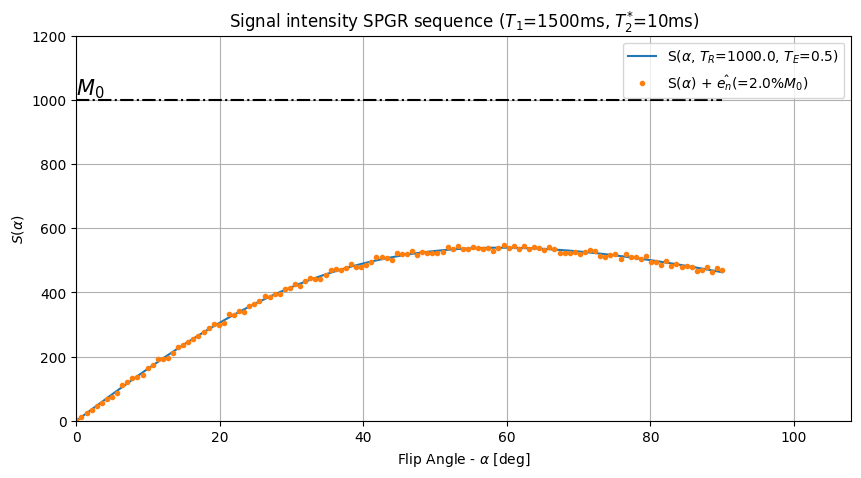

In [10]:
nt = 128
noise_factor = 0.02
[M0, T1, T2star] = [1000, 1500, 10]
flip_angles = np.linspace(0, 90, num=nt)

[TR, TE] = [1000.0, 0.5]
s_alpha = spgr_signal(M0, T1, TR, flip_angles, TE, T2star)
# Add white noise
en_alpha = noise_factor*M0*(np.random.rand(nt)-0.5)
s_alpha_noise = np.abs(s_alpha + en_alpha)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10.0, 5.0))
ax.plot(flip_angles, s_alpha, label=r'S($\alpha$, '+f'$T_R$={TR}, $T_E$={TE})')
ax.plot(flip_angles, s_alpha_noise, '.', label=r'S($\alpha$) + $\hat{e_n}$'+f'(={noise_factor*100:.1f}%$M_0$)')
ax.plot(flip_angles, M0*np.ones_like(flip_angles), 'k-.')
ax.text(flip_angles[0], M0, r'$M_0$', va='bottom', ha='left', fontsize=15)
ax.set_ylabel(r'$S(\alpha)$')
ax.set_xlabel(r'Flip Angle - $\alpha$ [deg]')
ax.set_title(f'Signal intensity SPGR sequence ($T_1$={T1}ms, '+r'$T_2^{*}$='+f'{T2star}ms)')
ax.legend(loc='best')
ax.grid(True)
ax.axis([0.0, 1.2*np.max(flip_angles), 0.0, 1.2*M0])
plt.show()


#### [VFA method - Linear approximation](#vfa-linear-approx)
If we consider the $T_2^{*}$ negligible (i.e. if $T_E << T_R$), the equation \ref{spgr} becomes independent of $E_2$. By acquiring multiple flip angles $\alpha_i$, while keeping everything else constant, the equation [2] \ref{spgr} can be linearised and $T_1$ can be derived from the slope of such straight line (see details in the appendix):

\begin{equation}
\frac{S_i}{\sin\alpha_i} = E_1\frac{S_i}{\tan\alpha_i} + M_0(1-E_1)
\end{equation}

Considering the following variable changes: 
$$
y=\frac{S_i}{\sin\alpha_i} \\\
x=\frac{S_i}{\tan\alpha_i}
$$
equation [previous] represents the linear function $y=mx+n$, where:
$$
m=E_1 \\\
n=M_0(1-E_1)
$$
from which we can derive $T_1$ from the slope $m$:
$$
E_1 = e^{-T_R/T_1} \qquad /\ln()\\\
-\frac{T_R}{T_1} = \ln(E_1) \\\
T_1 = -\frac{T_R}{\ln(m)}
$$
However, in practice this approximation is very rough and imprecise, hence we acquire multiple repetitions for each angles and do a non-linear fit of equation \ref{spgr}.

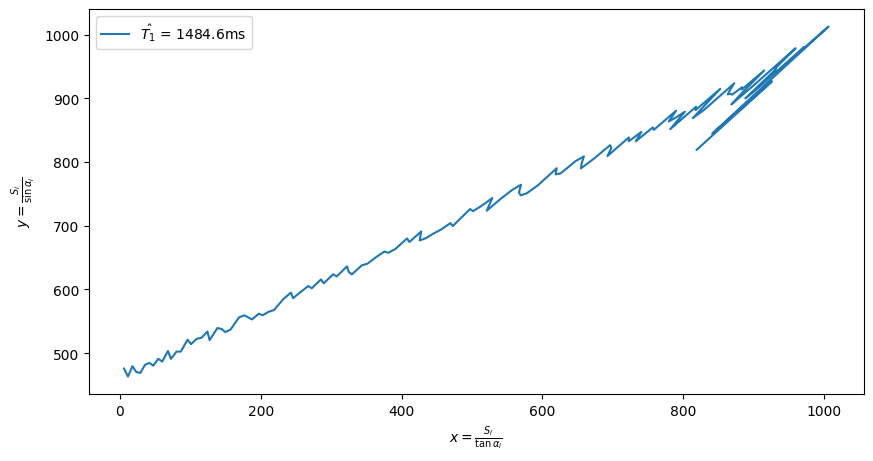

In [11]:
# Example of the linear approximation. 
# Remove the boundary conditions of the flip angles (i.e. 0 & 90 degree)
valid_fa = (flip_angles>0) & (flip_angles <90)
sin_alpha = np.sin(np.deg2rad(flip_angles))
tan_alpha = np.tan(np.deg2rad(flip_angles))
y = s_alpha_noise[valid_fa] / sin_alpha[valid_fa]
x = s_alpha_noise[valid_fa] / tan_alpha[valid_fa]
[m, n] = np.polyfit(x, y, deg=1)

T1hat = -TR / np.log(m)
M0hat = n/(1-m)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10.0, 5.0))
ax.plot(x, y, label=r'$\hat{T_1}$ = ' + f'{T1hat:.1f}ms')
ax.set_xlabel(r'$x=\frac{S_i}{\tan\alpha_i}$')
ax.set_ylabel(r'$y=\frac{S_i}{\sin\alpha_i}$')
ax.legend(loc='best')


#### [Non-Linear fit](#non-linear-fit-vfa)
Example of a nonlinear fit using LMFIT functions

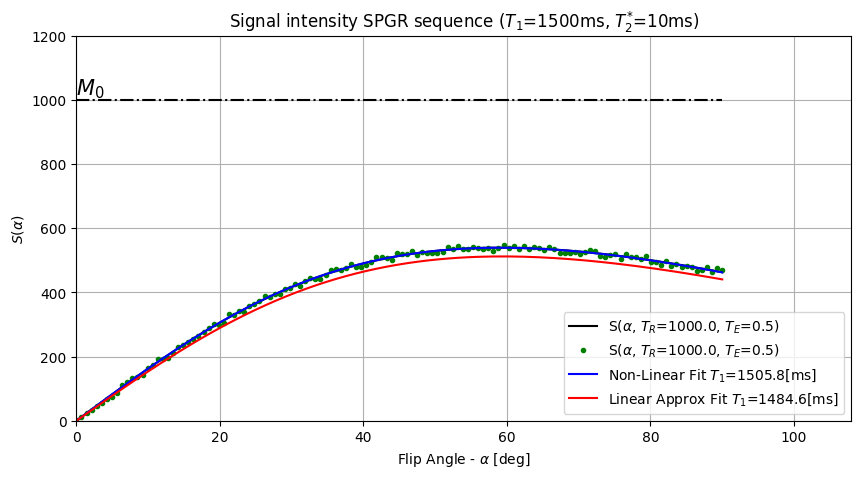

In [12]:
# Example non-linear fit
t1_opt_spgr = do_spgr_fit(s_alpha_noise, flip_angles, TR, TE, T2star, initial_s0=M0)
non_lin_fit_spgr_T1 = spgr_signal(t1_opt_spgr.params['s0'].value, 
                                  t1_opt_spgr.params['t1'].value,
                                  TR, flip_angles, TE, T2star)

lin_fit_spgr_T1 = spgr_signal(M0hat, T1hat,
                              TR, flip_angles, TE, T2star)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10.0, 5.0))
ax.plot(flip_angles, s_alpha, 'k-', label=r'S($\alpha$, '+f'$T_R$={TR}, $T_E$={TE})')
ax.plot(flip_angles, s_alpha_noise, 'g.', label=r'S($\alpha$, '+f'$T_R$={TR}, $T_E$={TE})')
ax.plot(flip_angles, non_lin_fit_spgr_T1, 'b-', label=f"Non-Linear Fit $T_1$={t1_opt_spgr.params['t1'].value:.1f}[ms]")
ax.plot(flip_angles, lin_fit_spgr_T1, 'r-', label=f"Linear Approx Fit $T_1$={T1hat:.1f}[ms]")
ax.plot(flip_angles, M0*np.ones_like(flip_angles), 'k-.')
ax.text(flip_angles[0], M0, r'$M_0$', va='bottom', ha='left', fontsize=15)
ax.set_ylabel(r'$S(\alpha)$')
ax.set_xlabel(r'Flip Angle - $\alpha$ [deg]')
ax.set_title(f'Signal intensity SPGR sequence ($T_1$={T1}ms, '+r'$T_2^{*}$='+f'{T2star}ms)')
ax.legend(loc='best')
ax.grid(True)
ax.axis([0.0, 1.2*np.max(flip_angles), 0.0, 1.2*M0])
plt.show()


### [Inversion Recovery Method](#ir-signal-equation)
This is considered the gold-standard for measuring T1. It uses the fact that an inversion pre-pulse increases the contrast to the double, compared to a normal saturation (e.g. SPGR). It is more accurate than the VFA method, but takes longer to aquire and technically is more challenging to achieve a correct inversion than an homogeneous flip angle.
The length of the acquisition is dominated by the fact that in order to achieve an accurate estimation, the TR must allow for the magnetisation to return to the equilibrium state, which means $T_R >> T_1$. In practice, a rule of thumb is that the equilibrium is achieved when $T_R \geq 5T_1$.
If the FOV of interest is large (e.g. breast imaging), the IR method is not suitable as the acquisition times get too long. For smaller FOV, the Look-Locker inversion method (MOLLI) can be used.
The general equation for the longintudinal magnetisation afer a pre-pulse of $\phi$ degrees ($\phi \in [90,180]^{o}$) is given by [[P. Kingsley et al; MRI 19:279-282; 2001](https://www.sciencedirect.com/science/article/abs/pii/S0730725X01002946)]:
\begin{equation} 
S(T_I) = S_0\biggl(1 - (1 - k_1)\exp(-T_I/T_1) - k_2 \exp(-(T_R - NTE)/T_1) \biggr)
\end{equation}

This model has 4 inputs:
* $T_I$:Preparation Time (Inversion Time in our case, but can also be the Saturation time)  
* $T_R$: Repetition time (i.e. time between successive inversion or preparation pulses)
* $NTE$: Duration of the echo train or readout time in the case of a single-shot sequence ($=N*TE$)
* C:  a flag (i.e. binary variable) to include or exclude the effect of the echoes in the $T_1$ function (see model in the next subsection)  

And up to 4 parameters [Kingsley et al.] that can be optimised:  
* $T_1$
* $S_0$
* $k_1$ (or $\phi$, as shown below)
* $k_2$

Depending on how many of these parameters are varied through the fitting, there are at least three possibilities we have to explore:
* Two parameters fit
    * $S_0$ and $T_1$ are the optimisation variables, any other parameter is fixed
* Three parameters fit
    * $S_0$, $T_1$, $k_1$ are the optimisation variables, any other parameter is fixed
* Four parameters fit:
    * $S_0$, $T_1$, $k_1$, $k_2$ are the optimisation variables.

According to [Kingsley et al. ], $k_1$ is defined as _the ratio of longitudinal magnetisation after the inversion to the longitudinal magnetisation before the inversion_ (i.e. $M_z/M_0$), which is equivalent to $\cos(\theta_{INV})$, with $\theta_{INV}$ the inversion angle (e.g. $\theta_{INV}=180^{\text{o}}$ for an Inversion Recovery sequence and $\theta_{INV}=90^{\text{o}}$ for a Saturation Recovery sequence).

$$ 1-k_1 = 1 - \cos(\theta_{INV}) $$

For the particular case of an Inversion Recovery method, where the expected ratio is $-1$, we have worked it in terms of the inversion efficiency, $\phi$. Both formulation are equivalent, but they may have impact on the dynamic range of each parameter (see next section).  

The additional parameter $k_2$ compensates any imperfection in the echo train length (e.g. imperfect refocusing pulse, inhomogeities), while $k_1$ compensates imperfect inversion (or saturation) in the preparation pulse(s). Both terms are related as $k_2$ is $k_1$ multiplied by a correction factor.  
* With perfect pulses, $k_1 = -1$ (i.e. $M_z/M_0=-1$, equivalently, $\theta_{INV} = 180^{\text{o}}$).  
* With no echoes, $k_1 = k_2$ Because no other RF pulse are applied, then only $k_1$ affects the recovery.  

Considering these assumptions, the signal equation for the ideal case with no echoes becomes:  
$$ S(T_I) = S_0\biggl(1 - (1 - k_1)\exp(-T_I/T_1) - k_1 \exp(-T_R/T_1) \biggr)$$
**which suggests the TR is not the whole acquisition time, but is indeed the difference between the time between inversions and the inversion time...**

Let see the timing diagram of a single slice HASTE:
<img src="diagrams/Slide1.png">  

##### $k_1$ or $\phi$??  
Focusing only in the inversion recovery method, we can assume the term $1-k_1 = 2$ in the ideal case, if perfect pulses. Alternatively, if imperfect or not full inversions (i.e. $\theta_{INV}<180^{\text{o}}$), then we add the inversion efficiency term, $\phi$ so the relationship becomes $1-k_1 = 2\phi$. The relationship between $k_1$, $k_2$ and $\phi$ can then be summarised as:
* $1-k_1 = 2\phi$  
* $k_1 \propto k_2 \rightarrow k_2 \propto 1-2\phi$

We can see from them, that $\phi\in [0,1]$, therefore $k_1 \in [-1, 1]$.  However, in [1] there is no constraints mentioned for $k_2$, apart that it is proportional to $k_1$. So in principle, $k_2 \in ]-\infty, \infty[$.  
** _Is this correct???_ **

***************************

##### How does $\phi$ relates to $\theta_{INV}$?
$1-k_1=2\phi=1-\cos(\theta_{INV}) \rightarrow \theta_{inv} = \arccos(1-2\phi)$  

Example:  
For an inversion efficiency of $80\%$ ($\phi = 0.8 $), it is equivalent to have an inversion angle of $127^{\text{o}}$


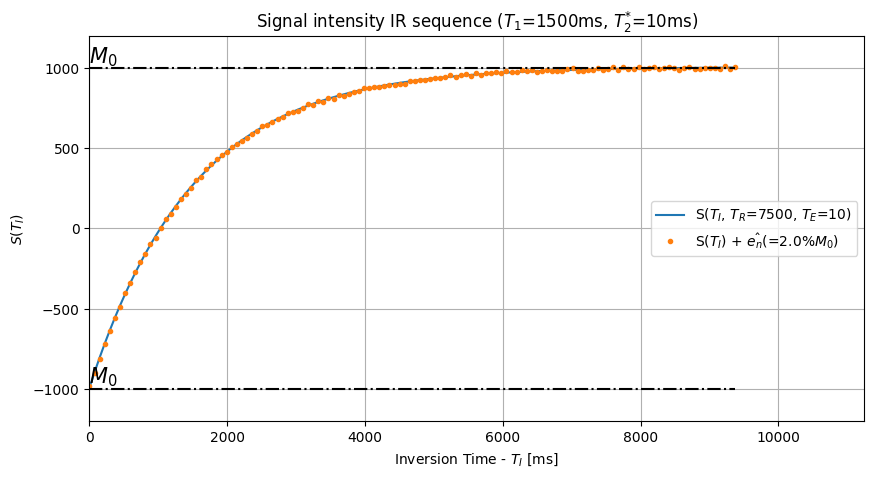

In [13]:
[TR, TE] = [5*T1, 10]
inversion_times = np.linspace(0.0, 1.25*TR, num=nt)
s_inversion = ir_signal(M0, T1, inversion_times, TR)
# Add white noise
noise_factor = 0.02
en_inv = noise_factor*M0*(np.random.rand(nt)-0.5)
s_inversion_noise = s_inversion + en_inv


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10.0, 5.0))
ax.plot(inversion_times, s_inversion, label=r'S($T_I$, '+f'$T_R$={TR}, $T_E$={TE})')
ax.plot(inversion_times, s_inversion_noise, '.', label=r'S($T_I$) + $\hat{e_n}$'+f'(={noise_factor*100:.1f}%$M_0$)')
ax.plot(inversion_times, M0*np.ones_like(inversion_times), 'k-.')
ax.text(inversion_times[0], M0, r'$M_0$', va='bottom', ha='left', fontsize=15)
ax.plot(inversion_times, -M0*np.ones_like(inversion_times), 'k-.')
ax.text(inversion_times[0], -M0, r'$M_0$', va='bottom', ha='left', fontsize=15)
ax.set_ylabel(r'$S(T_I)$')
ax.set_xlabel(r'Inversion Time - $T_I$ [ms]')
ax.set_title(f'Signal intensity IR sequence ($T_1$={T1}ms, '+r'$T_2^{*}$='+f'{T2star}ms)')
ax.legend(loc='best')
ax.grid(True)
ax.axis([0.0, 1.2*np.max(inversion_times), -1.2*M0, 1.2*M0])
plt.show()


#### [Non-Linear Fit](#non-linear-fit-ir)
Example fitting 3 parameters

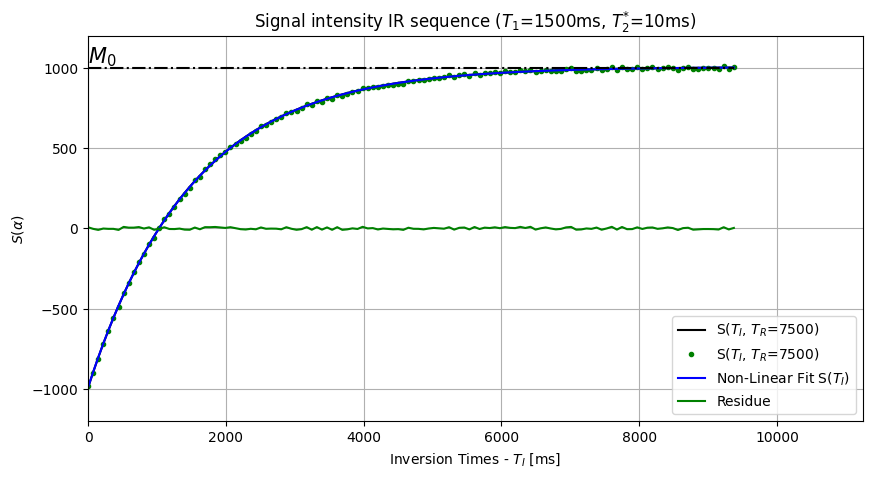

In [14]:
# Example non-linear fit    
t1_opt_ir = do_ir_fit(s_inversion_noise, inversion_times, TR)
non_lin_fit_ir_T1 = ir_signal(t1_opt_ir.params['s0'].value, 
                                  t1_opt_ir.params['t1'].value,
                                  inversion_times, TR, 
                                  f=t1_opt_ir.params['f'].value)
residual_ir_fit = s_inversion_noise - non_lin_fit_ir_T1

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10.0, 5.0))
ax.plot(inversion_times, s_inversion, 'k-', label=r'S($T_I$, '+f'$T_R$={TR})')
ax.plot(inversion_times, s_inversion_noise, 'g.', label=r'S($T_I$, '+f'$T_R$={TR})')
ax.plot(inversion_times, non_lin_fit_ir_T1, 'b-', label=r'Non-Linear Fit S($T_I$)')
ax.plot(inversion_times, residual_ir_fit, 'g-', label=r'Residue')
ax.plot(inversion_times, M0*np.ones_like(inversion_times), 'k-.')
ax.text(inversion_times[0], M0, r'$M_0$', va='bottom', ha='left', fontsize=15)
ax.set_ylabel(r'$S(\alpha)$')
ax.set_xlabel(r'Inversion Times - $T_I$ [ms]')
ax.set_title(f'Signal intensity IR sequence ($T_1$={T1}ms, '+r'$T_2^{*}$='+f'{T2star}ms)')
ax.legend(loc='best')
ax.grid(True)
ax.axis([0.0, 1.2*np.max(inversion_times), -1.2*M0, 1.2*M0])
plt.show()


## [Reference Tissue Method for T1](#reference-tissue-t1-method)

(tbc) - Add Reference
Gradient Echo Sequence with the following conditions:
* Flip Angles > $30^{o}$ 
* $T_R << T_1$ (i.e. magnetisation if highly saturated)
Tissue assumptions
* Differences in $T_2^{*}$ between both tissues are relatively low
* Similar proton density between both tissues

These conditions ensures the main assumption is valid:
* The product $S\times T_1$ is approximately constant (get reference to justify this!)

and the central relationship is:
\begin{equation}
\frac{S}{S_{ref}} \approx \frac{T_{1ref}}{T_1}
\end{equation}


## [PK models for MRI contrast agents](#pk-models-mri)

### [Population AIF](#aif-signal-equation)
In this section, an Arterial Input Function is defined by implementing the model proposed by [Parker et al. MRM 56(5): 993-1000; 2006](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.21066), derived from the fitting of two gaussians distributions and an exponential function modulated with a sigmoid function to the mean AIF measurements of 67 AIFs (see details in the publication cited):

\begin{equation}
AIF_{Parker}(t) = \sum_{n=1}^{2} \frac{A_n}{\sigma_n\sqrt{2\pi}}e^{-\frac{(t - T_n)^{2}}{2\sigma_n^{2}}} + \alpha \frac{e^{-\beta t}}{1 + e^{-s(t-\tau)}}
\end{equation}

with the parameters defined in Table 1 of [Parker et al. MRM 56(5): 993-1000; 2006](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.21066):

| Parameter |   $A_1$   |   $A_2$   |   $T_1$ | $T_2$  | $\sigma_1$ | $\sigma_2$ | $\alpha$ | $\beta$ |   s	   | $\tau$ |
| --------- | :----:    | :----:    | :----:  | :----: | :----:     | :----:     | :----:   | :----:  | :----: | :----: | 
| Value	    | 0.809	    | 0.330     | 0.17046 | 0.365  | 0.0563     | 0.132      | 1.050    | 0.1685  | 38.078 | 0.483  | 
| SD	    | 0.044	    | 0.040     | 0.00073 | 0.028  | 0.0011     | 0.021      | 0.017    | 0.0056  | 16.78  | 0.015  | 
| Units     | $\text{mmol} \cdot \text{min}$	| $\text{mmol} \cdot \text{min}$	| $\text{min}$	  | $\text{min}$	   | $\text{min}$	    | $\text{min}$        | $\text{mmol}$     | $\text{min}^{-1}$ | $\text{min}^{-1}$ | $\text{min}$    | 

More recently [Wang et al. MRI 34(2): 197-203; 2016](https://www.sciencedirect.com/science/article/abs/pii/S0730725X15002623) proposed the following functional form, with less parameters (8 instead of 10) and such that $C_p(t_{t=0}) = 0$:

\begin{equation}
AIF_{Wang}(t) = A \ln(1 + t) e^{-\beta t} (1 + \sum_{n=1}^{2} A_n e^{-\frac{(t-t_n)^{2}}{2\sigma_n^{2}}})
\end{equation}

with the parameters defined in Table 1 of [Wang et al. MRI 34(2): 197-203; 2016](https://www.sciencedirect.com/science/article/abs/pii/S0730725X15002623):

| Parameter |   $A$   |   $\beta$   |   $A_1$ | $\sigma_1$  | $t_1$   | $A_2$ | $\sigma_2$ | $t_2$  |   $R^{2}$ |
| --------- | :----:  | :----:     | :----:  |   :----:    | :----:  | :----:|  :----:    | :----: | :------: | 
| Value	    |  0.31 | 0.70 | 5.84 | 0.09 | 0.20 | 0.46 | 0.12 | 0.62 | 0.95 | 
| SD	    |  0.14 | 0.15 | 2.47 | 0.03 | 0.08 | 0.24 | 0.08 | 0.09 | 0.02 | 
| CV        |  0.44 | 0.22 | 0.42 | 0.38 | 0.40 | 0.52 | 0.65 | 0.15 | 0.02 |
| Units     | $\text{mmol}$	| $\text{min}^{-1}$	| []  | $\text{min}$ | $\text{min}$ | [] | $\text{min}$ | $\text{min}$ | [] | 



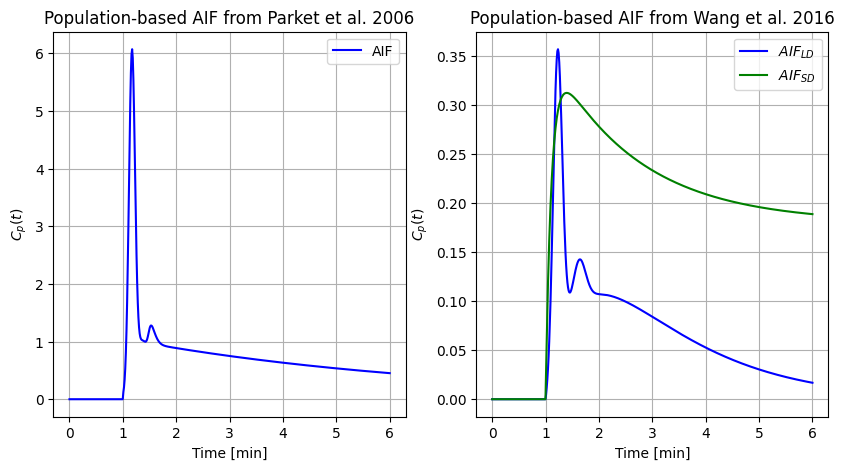

In [15]:
# Show population AIF:
offset = 1.0 # it means, the injectio occurred at t=offset[min]
tmax = 6.0 # min
marker_style = ''
time_axis = np.linspace(0.0, tmax, num=512) # min
aifParker = aif_parker(time_axis=time_axis, offset=offset)
aifWangLD = aif_wang(time_axis=time_axis, mode='LD', offset=offset)
aifWangSD = aif_wang(time_axis=time_axis, mode='SD', offset=offset)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10.0, 5.0))
ax[0].plot(time_axis, aifParker, 'b-', label='AIF', marker=marker_style)
ax[0].set_ylabel(r'$C_p(t)$')
ax[0].set_xlabel('Time [min]')
ax[0].set_title(f'Population-based AIF from Parket et al. 2006')
ax[0].legend(loc='best')
ax[0].grid(True)
# ax.axis([0.0, 1.2*np.max(inversion_times), -1.2*M0, 1.2*M0])

ax[1].plot(time_axis, aifWangLD, 'b-', label=r'$AIF_{LD}$', marker=marker_style)
ax[1].plot(time_axis, aifWangSD, 'g-', label=r'$AIF_{SD}$', marker=marker_style)
ax[1].set_ylabel(r'$C_p(t)$')
ax[1].set_xlabel('Time [min]')
ax[1].set_title(f'Population-based AIF from Wang et al. 2016')
ax[1].legend(loc='best')
ax[1].grid(True)
plt.show()


The [Matlab DRO](https://github.com/anstepsa/dce-dro-matlab) uses Parker's AIF so onwards I'll consider only that, but given Wang's is also implementted here, if needed, it'll be relatively straightforward to switch.

#### Comparing the analytical AIF
Available on Matlab DRO repo, is the AIF defined by the [QIBA DCE DROs](https://sites.duke.edu/dblab/qibacontent/) (not sure though from where exactly in the website it was taken), so I'll compare that with the analytical implementation in this notebook. The idea is to avoid the interpolation, instead to calculate point-by-point (TODO: check whether there is value on doing it that way or not)

* [QIBA AIF 5.4 Zero Offset](https://github.com/anstepsa/dce-dro-matlab/blob/main/aif/qiba_aif_5-4_zero_offset.csv)
* [PARKER AIF 6.1 ZERO Offset](https://github.com/anstepsa/dce-dro-matlab/blob/main/aif/parker_aif_6-1_zero_offset.csv)

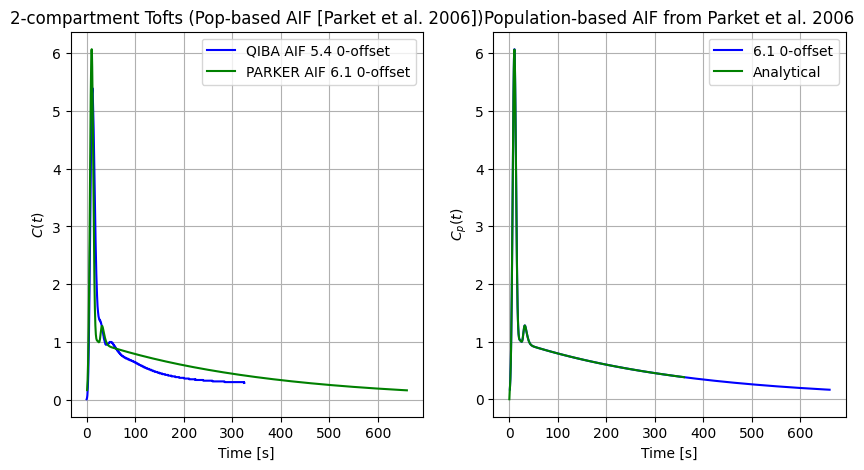

In [16]:
# Read AIF from QIBA datasets:
# Append the ?raw=true at the end, as suggested in https://stackoverflow.com/questions/55240330/how-to-read-csv-file-from-github-using-pandas
QIBAurl = 'https://github.com/anstepsa/dce-dro-matlab/blob/main/aif/qiba_aif_5-4_zero_offset.csv?raw=true'
PARKERurl = 'https://github.com/anstepsa/dce-dro-matlab/blob/main/aif/parker_aif_6-1_zero_offset.csv?raw=true'

qibaAIF = pd.read_csv(QIBAurl)
parkerAIF = pd.read_csv(PARKERurl)
aifParker = aif_parker(time_axis=time_axis, offset=0.0)

# qibaAIF = pd.read_csv(os.path.join('csv', 'qiba_aif_5-4_zero_offset.csv'))
# parkerAIF = pd.read_csv(os.path.join('csv', 'parker_aif_6-1_zero_offset.csv'))

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10.0, 5.0))
qibaAIF.plot(x='t_s', y=' Cb_mM', ax=ax[0], label='QIBA AIF 5.4 0-offset', color='b', linestyle='-')
parkerAIF.plot(x='t_s', y='Cb_mM', ax=ax[0], label='PARKER AIF 6.1 0-offset', color='g', linestyle='-')
# ax.plot(qibaAIF['t_s'], cTofts_parkersAIF, 'b-', label=r'$C(t)$ (Parker AIF)')
# ax.plot(time_axis, cTofts_wangLDAIF, 'r-', label=r'$C(t)$ (Wang AIF)')
ax[0].set_ylabel(r'$C(t)$')
ax[0].set_xlabel('Time [s]')
ax[0].set_title(f'2-compartment Tofts (Pop-based AIF [Parket et al. 2006])')
ax[0].legend(loc='best')
ax[0].grid(True)

parkerAIF.plot(x='t_s', y='Cb_mM', ax=ax[1], label='6.1 0-offset', color='b', linestyle='-')
ax[1].plot(time_axis*60, aifParker, 'g-', label='Analytical')
ax[1].set_ylabel(r'$C_p(t)$')
ax[1].set_xlabel('Time [s]')
ax[1].set_title(f'Population-based AIF from Parket et al. 2006')
ax[1].legend(loc='best')
ax[1].grid(True)
# ax.axis([0.0, 1.2*np.max(inversion_times), -1.2*M0, 1.2*M0])


### [Tofts Models](#tofts-pk-models)
#### [Single compartment model](#tofts-model)

\begin{equation}
C(t) = K^{trans}\int_{0}^{t}C_p(\tau)e^{-k_{ep}(t-\tau)}d\tau
\end{equation}

with $k_{ep}=\frac{K^{trans}}{v_e}$

#### [2-compartment model (extended Tofts)](#tofts-extended-model)

\begin{equation}
C(t) = v_PC_p(t) + K^{trans}\int_{0}^{t}C_p(\tau)e^{-\frac{K^{trans}(t-\tau)}{v_e}}d\tau
\end{equation}

with:
* $t$ the observation time (in minutes to be consistent with parameters units)
* $K^{trans}$, the **volume transfer constant between blood plasma and EE**, in $min^{-1}$
* $v_e$, the **extravascular extracellular fractional volume**
* $C_p(t)$, the **AIF–blood plasma contrast agent concentration** (see previous section), in units of $mM$ (i.e. mmole/L)

The main hypothesis of this model is that "*when a very sharp bolus of contrast media enters tissue (e.g. a tumor), contrast media diffuses from capillaries into the EES, and subsequently $C(t)$ decays exponentially with a time constant of $\frac{K_{trans}}{v_e}$*" [Chapter 12 - Breast MRI]. 

#### Examples

##### Tofts vs Extended (2-compartment) Tofts

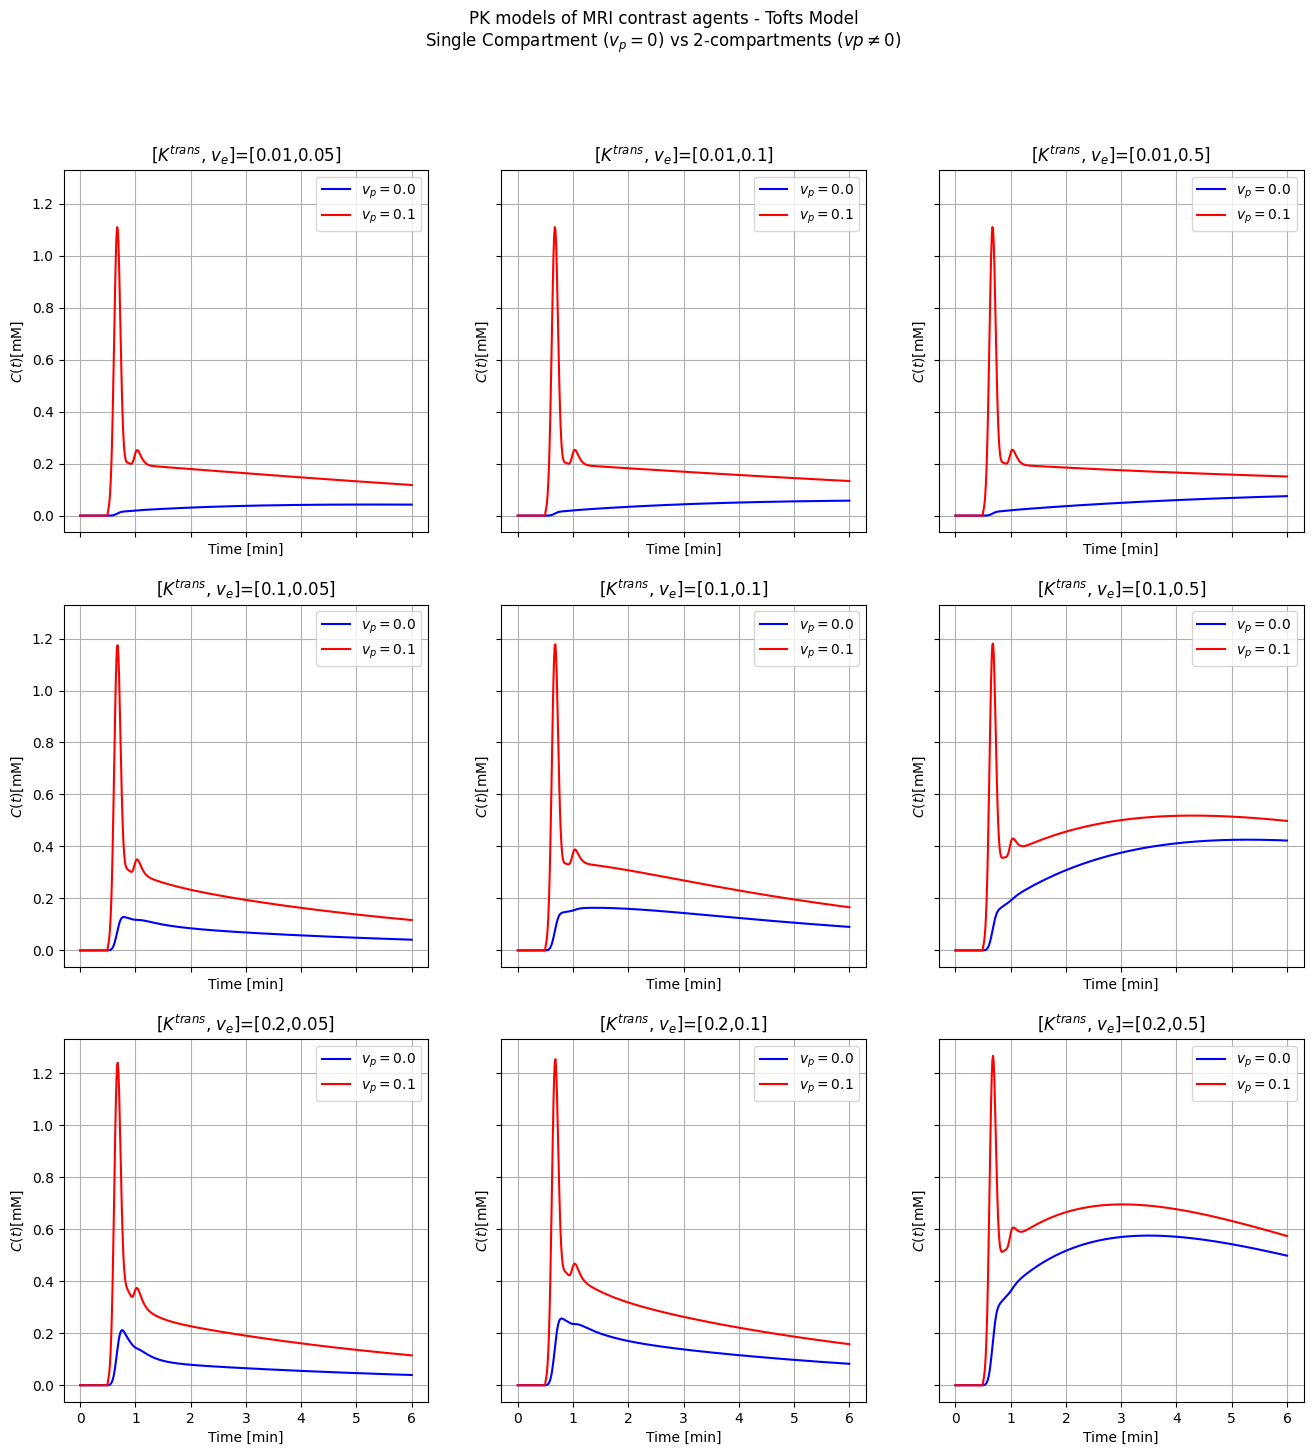

In [17]:
# Examples taken from https://github.com/anstepsa/dce-dro-matlab/blob/main/config/param_values_eTM_examp_001.csv
Ktrans  = [0.01, 0.1, 0.2]
ve      = [0.05, 0.1, 0.5] 
vp      = [0.0, 0.1]
line_styles = ['b-','r-']

nt = 512
# Show time curve concentration
tmax = 6.0 # min
time_axis = np.linspace(0.0, tmax, num=nt) # min
fig, ax = plt.subplots(ncols=len(ve), nrows=len(Ktrans), figsize=(16.0, 16.0), sharex=True, sharey=True)

for indKtrans in range(len(Ktrans)):
    for indVe in range(len(ve)):
        for indVp in range(len(vp)):
            cTofts_parkersAIF = tofts2C(time_axis, Ktrans[indKtrans], ve[indVe], vp[indVp], aif='parker', offset=0.5)

            ax[indKtrans, indVe].plot(time_axis, cTofts_parkersAIF, line_styles[indVp], label=r'$v_p=$'+f'{vp[indVp]}')

            ax[indKtrans, indVe].set_ylabel(r'$C(t)$[mM]')
            ax[indKtrans, indVe].set_xlabel('Time [min]')
            ax[indKtrans, indVe].set_title(r'[$K^{trans}$, $v_{e}$]=['+f'{Ktrans[indKtrans]},{ve[indVe]}]')
            ax[indKtrans, indVe].legend(loc='best')
            ax[indKtrans, indVe].grid(True)

fig.suptitle('\n'.join(['PK models of MRI contrast agents - Tofts Model',r'Single Compartment ($v_p=0$) vs 2-compartments ($vp\neq0$)']))
plt.show()


##### Extended Tofts Model

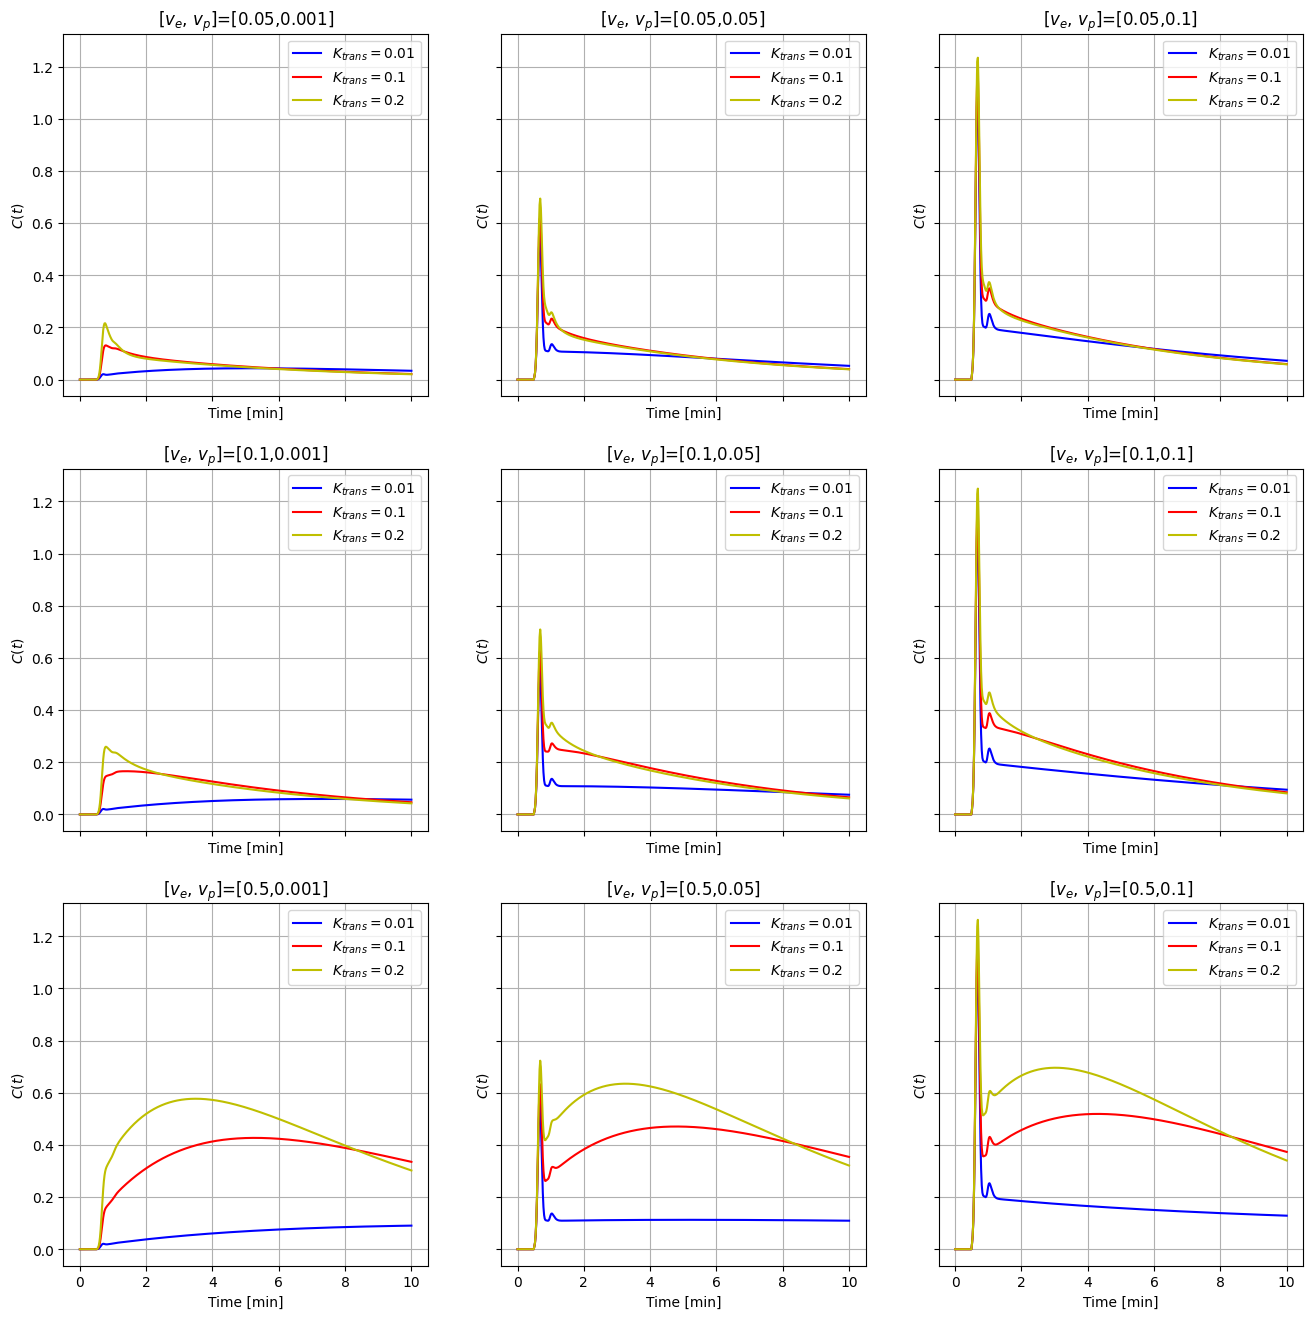

In [516]:
# Examples taken from https://github.com/anstepsa/dce-dro-matlab/blob/main/config/param_values_eTM_examp_001.csv
Ktrans  = [0.01, 0.1, 0.2]
ve      = [0.05, 0.1, 0.5] 
vp      = [0.001, 0.05, 0.1]
line_styles = ['b-','r-','y-']

fig, ax = plt.subplots(ncols=len(vp), nrows=len(ve), figsize=(16.0, 16.0), sharex=True, sharey=True)

for indVp in range(len(vp)):
    for indVe in range(len(ve)):
        for indKtrans in range(len(Ktrans)):
            cTofts_parkersAIF = tofts2C(time_axis, Ktrans[indKtrans], ve[indVe], vp[indVp], aif='parker', offset=0.5)

            ax[indVe, indVp].plot(time_axis, cTofts_parkersAIF, line_styles[indKtrans], label=r'$K_{trans}=$'+f'{Ktrans[indKtrans]}')

            ax[indVe, indVp].set_ylabel(r'$C(t)$')
            ax[indVe, indVp].set_xlabel('Time [min]')
            ax[indVe, indVp].set_title(r'[$v_{e}$, $v_{p}$]=['+f'{ve[indVe]},{vp[indVp]}]')
            ax[indVe, indVp].legend(loc='best')
            ax[indVe, indVp].grid(True)

plt.show()


### [$T_1$ and contrast media concentrations](#t1-ca-concentrations)
To simplify the analysis, I'll assume the tissue of interest and the contrast agent are in the fast-exchange regime (ref Yenkeelov et al.), so the relationships are direct and linear. Later on, I'll include sophistications and deviations from this situation. For now, in the fast-exchange regime, the relationship between the shortening of $T_1$ and the contrast agent is given by:
\begin{equation}
\frac{1}{T_1(c(t))} = \frac{1}{T_{10}} + r_1c(t)
\end{equation}
where $c(t)$ is the concentration of contrast agent, that varies over time (e.g. during washin/washout), $T_{10}$ the baseline $T_1$ of the tissue, i.e. the native $T_1$ that depends on the tissue and the main magnetic field, and $r_1$ the relaxivity of the contrast media, which is a constant for each agent and also depends on the main magnetic field (see Appendix 2 for relaxivity values of several contrast agents at 1.5T). $T_1(c(t))$ is the modified $T_1$ of the tissue, due to presence of the contrast agent. In the following figure, an example of different combinations of $T_{10}$, $c(t)$ and $r_1$ is shown over time.



In [19]:
# Relaxivities at 1.5T & 37C (see Appendix 2)
relaxivities = {'magnevist': 4.1,
                'multihance': 6.3,
                'omniscan': 4.3,
                'dotarem': 3.6,
                'prohance': 4.1, 
                'gadavist': 5.2,
                'eovist': 6.9,
                'vueway': 12.8 
                }
# Average T1 values of some tissues at 1.5T (see Appendix 2)
tissues_T1 = {
    'water'            : 4000,
    'csf'              : 4000, # same as water
    'gray matter'      : 900,
    'muscle'           : 900,
    'liver'            : 500,
    'fat'              : 250,
    'tendon'           : 400,
    'proteins'         : 250,
    'ice'              : 5000,
    'breast_fat'       : 334,  # Rakow-Penner et al. 2006
    'breast_glandular' : 1201, # Rakow-Penner et al. 2006
    'breast_tumour'    : 876,  # Hendriks et al. citing Merchant TE 1993
    }


#### Example

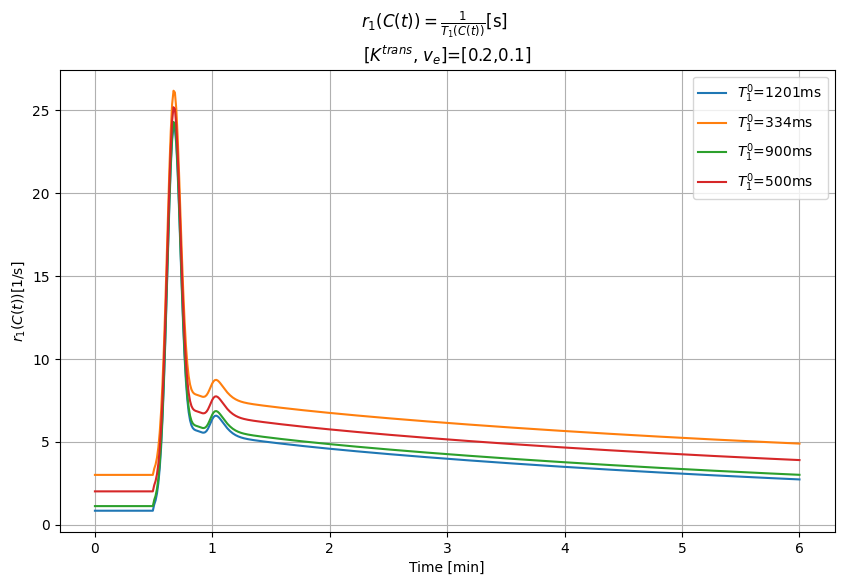

In [530]:
# Examples taken from https://github.com/anstepsa/dce-dro-matlab/blob/main/config/param_values_eTM_examp_001.csv
Ktrans  = 0.2
ve      = 0.1 
vp      = 0.5
# Ktrans  = 0.2
# ve      = 0.5 
# vp      = 0.05
r1 = relaxivities['magnevist']
T10 = [tissues_T1['breast_glandular'],
       tissues_T1['breast_fat'],
       tissues_T1['muscle'],
       tissues_T1['liver'],
      ]

nt = 512
# Show time curve concentration
tmax = 6.0 # min
time_axis = np.linspace(0.0, tmax, num=nt) # min

ct      = tofts2C(time_axis, Ktrans, ve, vp, offset=0.5)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10.0, 6.0))

for t1BL in T10:
    r1ct    = r1_contrast(t1BL, r1, ct)
    ax.plot(time_axis, r1ct, label=r'$T_{1}^{0}$='+f'{t1BL}ms')

ax.set_ylabel(r'$r_1(C(t))$[1/s]')
ax.set_xlabel('Time [min]')
ax.set_title(r'[$K^{trans}$, $v_{e}$]=['+f'{Ktrans},{ve}]')
ax.legend(loc='best')
ax.grid(True)

fig.suptitle(r'$r_1(C(t))=\frac{1}{T_1(C(t))}$[s]')
plt.show()


# [MRI Signal from T1 curves - Simulations](#mri-signal-from-t1)
This is an inverse problem, where we derive an estimated signal intensity from the concentration of contrast agent in a tissue with baseline $T_1$

In [531]:
# Parameters common to all the examples shown in here
nt = 512
T10 = [tissues_T1['breast_glandular'],
       tissues_T1['breast_fat'],
       tissues_T1['muscle'],
       tissues_T1['liver'],
      ]
# Dynamic experiment duration and time axis
tmax = 10.0 # min
time_axis = np.linspace(0.0, tmax, num=nt) # min

# Acquisition parameters
FA_deg = 10
TR = 100

# PK parameters
Ktrans  = 0.2
ve      = 0.1 
vp      = 0.5

# Concentration curve
ct      = tofts2C(time_axis, Ktrans, ve, vp, offset=0.5)


## [SPGR signal equation example](#inverse-problem-spgr)
In the case of the SPGR sequence, we generalise the equation defined in the [Spoiled Gradient Echo section](#spoiled-gradient-echo-with-variable-flip-angle))

\begin{equation}
S(M_0, \alpha, T_E, T_R, T_1(t), T_2^{*}) = M_0\sin\alpha\frac{1 - E_1(T_1(t),T_R)}{1 - (\cos\alpha)E_1(T_1(t),T_R)}E_2(T_2^{*}, T_E)
\end{equation}

assuming everything is constant, we can then replace T1(t) into E1 directly. However, to simplify the math, in the concentration formula, we replace the $T_1$ terms by their inverse, or relaxivity $R_1(t)$:
\begin{equation}
R_1(c(t)) = R_{10} + r_1c(t)
\end{equation}

and the $E_1$ term becomes:
\begin{equation}
E_1(R_1(c(t)), T_R) = e^{-(R_{10}+r_1c(t))T_R}
\end{equation}

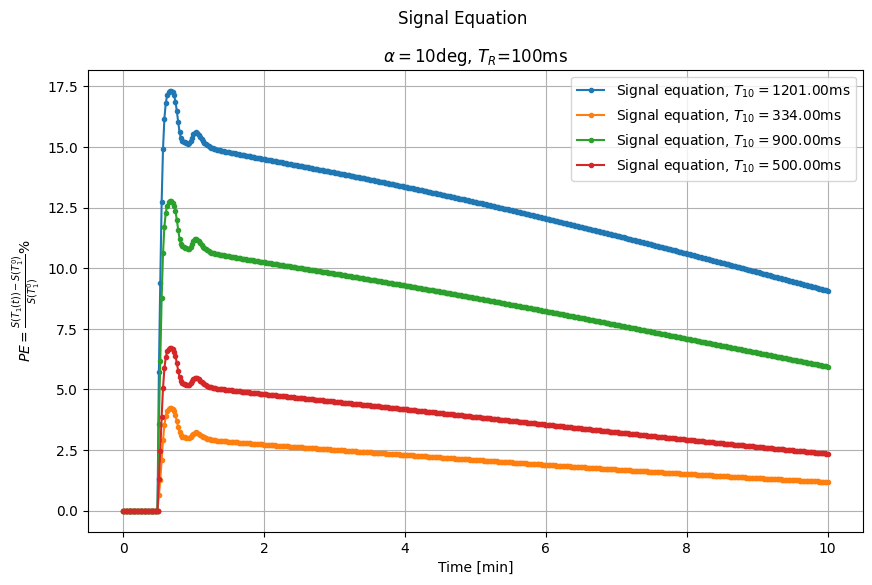

In [532]:
R1t = np.zeros((len(T10), len(ct)))
StSPGR = np.zeros((len(T10), len(ct)))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10.0, 6.0))

for indt1, t1BL in enumerate(T10):
    R1t[indt1, :]    = r1_contrast(t1BL, r1, ct) # R1 is in 1/seconds (see notes in function r1_contrast)
    StSPGR[indt1, :] = spgr_signal(1000.0, 1000.0/R1t[indt1, :], TR, FA_deg, TE, T2star)
    S0 = StSPGR[indt1, 0]
    ax.plot(time_axis, 100 * (StSPGR[indt1, :] - S0) / S0, '.-',label=r'Signal equation, $T_{10}=$'+f'{t1BL:.2f}ms')

ax.set_ylabel(r'$PE=\frac{S(T_1(t)) - S(T_1^0)}{S(T_1^0)}\%$')
ax.set_xlabel('Time [min]')
ax.set_title(r'$\alpha = $'+f'{FA_deg}deg' + r', $T_R$='+f'{TR}ms')
ax.legend(loc='best')
ax.grid(True)

fig.suptitle('Signal Equation')
plt.show()


## 1D 3-Tissues example

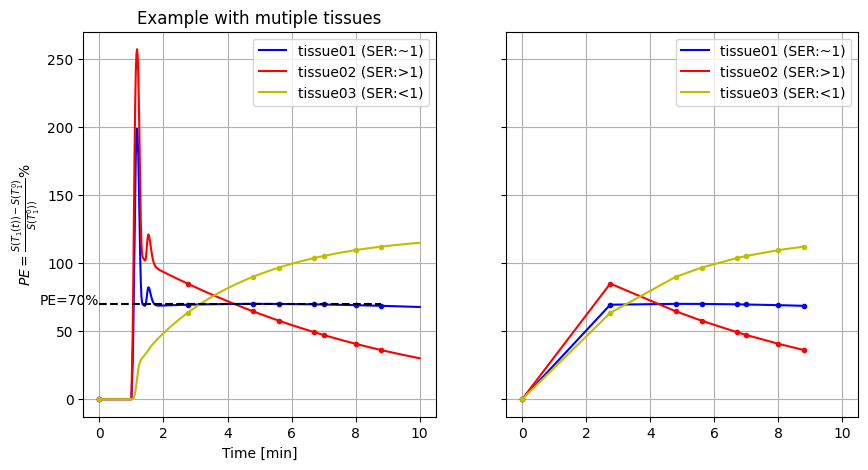

In [533]:
# 3 tissues with different baseline T1, Ktrans, ve and vp values:
Tissues = {'tissue01': {'T1bl': 1200,
                        'T2star': 10,
                        'M0': 1000.0,
                        'Ktrans': 0.02,
                        've': 0.8,
                        'vp': 0.1,
                        'colour': 'b',
                        'SER': '~1',
                        },
           'tissue02': {'T1bl': 1200,
                        'T2star': 10,
                        'M0': 1000.0,
                        'Ktrans': 0.5,
                        've': 0.001,
                        'vp': 0.2,
                        'colour': 'r',
                        'SER': '>1',
                        },
           'tissue03': {'T1bl': 1200,
                        'T2star': 10,
                        'M0': 1000.0,
                        'Ktrans': 0.05,
                        've': 2.0,
                        'vp': 0.0,
                        'colour': 'y',
                        'SER': '<1',
                        }
}

ContrastAgent = {'r1': relaxivities['magnevist'],
}

SPGR_parameters = {'TR': 5.0,
                   'TE': 2.5,
                   'FA': 10,
                   'B1': 1   
}

time_points = [0.0, 2.75, 4.8, 5.6, 6.7, 7,8, 8.8] #min

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10.0, 5.0), sharex=True, sharey=True)

for tissueID, tissue_pars in Tissues.items():
    ca_timecurve = tofts2C(time_axis, tissue_pars['Ktrans'], tissue_pars['ve'], tissue_pars['vp'], aif='parker', offset=1.0)
    r1_timecurve = r1_contrast(tissue_pars['T1bl'], ContrastAgent['r1'], ca_timecurve)
    StSPGR = spgr_signal(tissue_pars['M0'], 1000.0/r1_timecurve, 
                         SPGR_parameters['TR'],
                         SPGR_parameters['FA'], 
                         SPGR_parameters['TE'], 
                         tissue_pars['T2star'])
    St_HSR = np.interp(time_points, time_axis, 100*(StSPGR-StSPGR[0])/StSPGR[0])
    ax[0].plot(time_axis, 100*(StSPGR-StSPGR[0])/StSPGR[0], tissue_pars['colour'], label=f"{tissueID} (SER:{tissue_pars['SER']})")
    ax[0].plot(time_points, St_HSR, tissue_pars['colour']+'.')
    ax[1].plot(time_points, St_HSR, tissue_pars['colour']+'.')
    ax[1].plot(time_points, St_HSR, tissue_pars['colour'], label=f"{tissueID} (SER:{tissue_pars['SER']})")
    
ax[0].plot(time_points, np.full_like(time_points, 70.0),'k--')
ax[0].text(time_points[0], 70.0, 'PE=70%', ha='right')
ax[0].set_ylabel(r'$PE = \frac{S(T_1(t))-S(T_1^0)}{S(T_1^0))}\%$')
ax[0].set_xlabel('Time [min]')
ax[0].set_title('Example with mutiple tissues')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid(True)
ax[1].grid(True)

plt.show()



## 1D multi-tissue example
Image Parameters:
|Parameter | Values |  Units |
| :----:   | :----: | :----: | 
|Image Dimensions | $[528 \times 528 \times 120]$ | pixels |
|Image Resolutions | $[0.68 \times 0.68 \times 1.5]$ | mm/pixels |
| TR | 5.2 | ms|
| TE | 2.5 | ms|
| FA | 10  | degree|

Tissues Relaxation Times:
| Tissue | $T_1$ [ms] | $T_2$ [ms] |
| :----: |    :----:  |   :----:   |
|Breast Fat     |  334  | 53 |
|Glandular Breast Tissue | 1201 | 58 |
|Breast Malignant Tissue | 876  | 75 |
|Blood          |  1434  | 254 |
|Major Muscle   |   900  |  50 |
| Water/CSF     |  4000  |  2000 |



In [582]:
image_pars = {'dimensions': [528, 528, 120],
              'resolution': [0.68, 0.68, 1.5],
              'TR': 5.2,
              'ETL': 42,
              'TE': 2.5,
              'FA': 10,
              'pFOV': 130,
              'pPE': 80, 
              'pSL': 2.0, # Slice Overlap factor (i.e. )
              'nBits': 16
              }
tissue_pars = {'breast_fat': {'T1': 334,
                              'T2': 53,
                              'M0': 1000.0,
                              'Ktrans': 0.1,
                              've': 0.01,
                              'vp': 0.01,
                              'colour': 'gray',
                              },
               'breast_glandular': {'T1': 1201,
                                    'T2': 58,
                                    'M0': 5000.0,
                                    'Ktrans': 0.01,
                                    've': 0.01,
                                    'vp': 0.01,
                                    'colour': 'magenta',
                                    },
               'breast_malignancy': {'T1': 876,
                                     'T2': 75,
                                     'M0': 5000.0,
                                     'Ktrans': 1.5, # average for malignant mass, as indicated in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3737611/
                                     've': 1.5,
                                     'vp': 0.01,
                                     'colour': 'red',
                                     },
               'arterial_blood': {'T1': 1434,
                                  'T2': 254,
                                  'M0': 7000.0,
                                  'Ktrans': 2.0,
                                  've': 0.01,
                                  'vp': 2.0,
                                  'colour': 'orange',                              
                                  },
               'major_muscle': {'T1': 900,
                                'T2': 50,
                                'M0': 3000.0,
                                'Ktrans': 0.01,
                                've': 0.01,
                                'vp': 0.01,
                                'colour': 'blue',
                                },
               'water_csf': {'T1': 4000,
                             'T2': 2000,
                             'M0': 10000.0,
                             'Ktrans': 0.01,
                             've': 0.01,
                             'vp': 0.01,
                             'colour': 'green',
                             },
               }


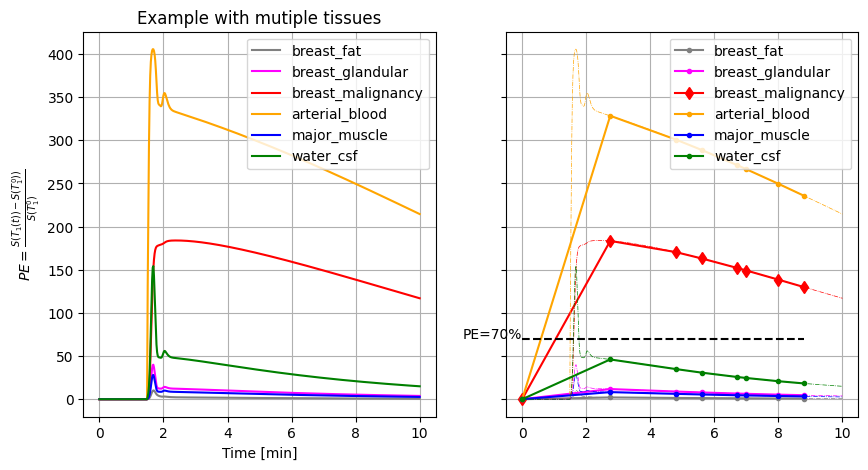

In [583]:
offset = 1.5 # Injection time respect to baseline acquisition

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10.0, 5.0), sharex=True, sharey=True)

for tissueID, tissueMRI in tissue_pars.items():
    ca_timecurve = tofts2C(time_axis, tissueMRI['Ktrans'], tissueMRI['ve'], tissueMRI['vp'], aif='parker', offset=offset)
    r1_timecurve = r1_contrast(tissueMRI['T1'], ContrastAgent['r1'], ca_timecurve)

    tissueSPGRt = spgr_signal(tissueMRI['M0'], 1000.0/r1_timecurve,
                              image_pars['TR'], 
                              image_pars['FA'],
                              image_pars['TE'],
                              tissueMRI['T2'])
    S0 = tissueSPGRt[0]
    
    St_HSR = np.interp(time_points, time_axis, tissueSPGRt-S0)
    if tissueID == 'breast_malignancy':
        marker = 'd'
    else:
        marker = '.'

    ax[0].plot(time_axis, 100 * (tissueSPGRt - S0)/S0, tissueMRI['colour'], label=f"{tissueID}")
    
    ax[1].plot(time_points, 100 * (St_HSR / S0), tissueMRI['colour'], linestyle='-', marker=marker, label=f"{tissueID}")
    ax[1].plot(time_axis, 100 * (tissueSPGRt - S0) / S0, tissueMRI['colour'], linestyle='-.', linewidth=0.5)
 
     
ax[1].plot(time_points, np.full_like(time_points, 70.0),'k--')
ax[1].text(time_points[0], 70.0, 'PE=70%', ha='right')
ax[0].set_ylabel(r'$PE = \frac{S(T_1(t)) - S(T_1^0))}{S(T_1^0)}$')
ax[0].set_xlabel('Time [min]')
ax[0].set_title('Example with mutiple tissues')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid(True)
ax[1].grid(True)

plt.show()


## 4D multi-tissue example

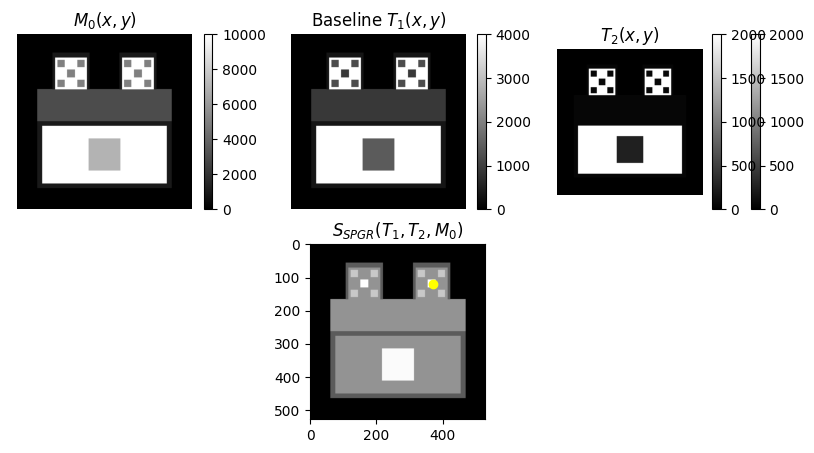

In [266]:
# Create shape phantom - use opencv to draw shape in an image
image_dim  = [528, 528, 1] # pixels
image_res  = [0.68, 0.68, 1.5] # mm/pix
image_size = [imdim*imgres for imdim, imgres in zip(image_dim, image_res)]

T1map = np.zeros((image_dim))
T2map = np.zeros((image_dim))
M0map = np.zeros((image_dim))

# labels:
# Give the points in mm and convert them to pixels:
regions = {'outer_region': {'ab': (42.02, (image_dim[1]*image_res[1]) - 180.6),
                            'cd': (317.02, (image_dim[1]*image_res[1]) - 43),
                            'label': 'breast_fat',
                            },
           'inner_region': {'ab': (52.02, (image_dim[1]*image_res[1]) - 170.6),
                            'cd': (307.02,(image_dim[1]*image_res[1]) -  53),
                            'label': 'water_csf',
                            },
           'blood_pool': {'ab': (147.02, (image_dim[1]*image_res[1]) - 144.3),
                            'cd': (212.02,(image_dim[1]*image_res[1]) -  79.3),
                            'label': 'arterial_blood',
                            },
           'major_muscle': {'ab': (42.02, (image_dim[1]*image_res[1]) - 245.6),
                            'cd': (317.02,(image_dim[1]*image_res[1]) -  180.6),
                            'label': 'major_muscle',
                            },
           'right_breast_ocontour': {'ab': (73.27, (image_dim[1]*image_res[1]) - 320.6),
                            'cd': (148.27, (image_dim[1]*image_res[1]) - 245.6),
                            'label': 'breast_fat',
                            },
           'left_breast_ocontour': {'ab': (210.77, (image_dim[1]*image_res[1]) - 320.6),
                            'cd': (285.77, (image_dim[1]*image_res[1]) - 245.6),
                            'label': 'breast_fat',
                            },
           'right_breast_icontour': {'ab': (78.27, (image_dim[1]*image_res[1]) - 310.6),
                            'cd': (143.27, (image_dim[1]*image_res[1]) - 245.6),
                            'label': 'water_csf',
                            },
           'left_breast_icontour': {'ab': (215.77, (image_dim[1]*image_res[1]) - 310.6),
                            'cd': (280.77, (image_dim[1]*image_res[1]) - 245.6),
                            'label': 'water_csf',
                            },
           'tumour_tissue_right': {'ab': (102.77, (image_dim[1]*image_res[1]) - 286.1),
                            'cd': (118.77, (image_dim[1]*image_res[1]) - 270.1),
                            'label': 'breast_malignancy',
                            },           
           'tumour_tissue_left': {'ab': (240.27, (image_dim[1]*image_res[1]) - 286.1),
                            'cd': (256.27, (image_dim[1]*image_res[1]) - 270.1),
                            'label': 'breast_malignancy',
                            },
           'breast_glandular_tissue_right_001': {'ab': (83.27, (image_dim[1]*image_res[1]) - 305.6),
                            'cd': (97.27, (image_dim[1]*image_res[1]) - 291.6),
                            'label': 'breast_glandular',
                            },
           'breast_glandular_tissue_right_002': {'ab': (83.27, (image_dim[1]*image_res[1]) - 264.6),
                            'cd': (97.27, (image_dim[1]*image_res[1]) - 250.6),
                            'label': 'breast_glandular',
                            },
           'breast_glandular_tissue_right_003': {'ab': (124.27, (image_dim[1]*image_res[1]) - 305.6),
                            'cd': (138.27, (image_dim[1]*image_res[1]) - 291.6),
                            'label': 'breast_glandular',
                            },
           'breast_glandular_tissue_right_004': {'ab': (124.27, (image_dim[1]*image_res[1]) - 264.6),
                            'cd': (138.27, (image_dim[1]*image_res[1]) - 250.6),
                            'label': 'breast_glandular',
                            },
           'breast_glandular_tissue_left_001': {'ab': (220.27, (image_dim[1]*image_res[1]) - 305.6),
                            'cd': (234.27, (image_dim[1]*image_res[1]) - 291.6),
                            'label': 'breast_glandular',
                            },
           'breast_glandular_tissue_left_002': {'ab': (220.27, (image_dim[1]*image_res[1]) - 264.6),
                            'cd': (234.27, (image_dim[1]*image_res[1]) - 250.6),
                            'label': 'breast_glandular',
                            },
           'breast_glandular_tissue_left_003': {'ab': (261.27, (image_dim[1]*image_res[1]) - 305.6),
                            'cd': (275.27, (image_dim[1]*image_res[1]) - 291.6),
                            'label': 'breast_glandular',
                            },
           'breast_glandular_tissue_left_004': {'ab': (261.27, (image_dim[1]*image_res[1]) - 264.6),
                            'cd': (275.27, (image_dim[1]*image_res[1]) - 250.6),
                            'label': 'breast_glandular',
                            },
}

nlabel = len(regions)
for regionID, regionData in regions.items():
    # convert the points from mm to pixels:
    ab = [int(XYmm/XYres) for XYmm, XYres in zip(regionData['ab'], image_res[:-1])]
    cd = [int(XYmm/XYres) for XYmm, XYres in zip(regionData['cd'], image_res[:-1])]
    cv2.rectangle(T1map,ab,cd,((tissue_pars[regionData['label']]['T1'])),-1)
    cv2.rectangle(T2map,ab,cd,((tissue_pars[regionData['label']]['T2'])),-1)
    cv2.rectangle(M0map,ab,cd,((tissue_pars[regionData['label']]['M0'])),-1)

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10.0, 5.0))
im = ax[0,0].imshow(M0map, cmap='gray')
ax[0,0].set_title(r'$M_0(x,y)$')
ax[0,0].axis('off')
fig.colorbar(im, ax=ax[0,0])

im = ax[0,1].imshow(T1map, cmap='gray')
ax[0,1].set_title(r'Baseline $T_1(x,y)$')
ax[0,1].axis('off')
fig.colorbar(im, ax=ax[0,1])

im = ax[0,2].imshow(T2map, cmap='gray')
ax[0,2].set_title(r'$T_2(x,y)$')
ax[0,2].axis('off')
fig.colorbar(im, ax=ax[0,2])

S_SPGR = spgr_signal(M0map, T1map, image_pars['TR'], image_pars['FA'], image_pars['TE'], T2map)
ax[1,1].imshow(S_SPGR, cmap='gray')
ax[1,1].set_title(r'$S_{SPGR}(T_1, T_2, M_0)$')
ax[1,1].plot(370, 120, '.',markersize=12, color='yellow')
# ax[1,1].axis('off')
ax[1,0].axis('off')
ax[1,2].axis('off')
fig.colorbar(im, ax=ax[0,2])

plt.show()


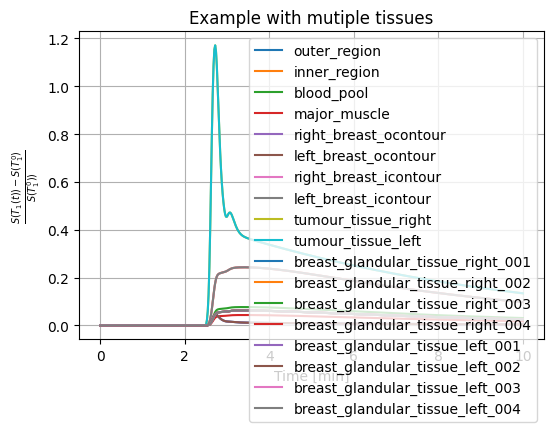

In [216]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6.0, 4.0), sharex=True, sharey=True)

for regionID, regionData in regions.items():
    
    ca_timecurve = tofts(time_axis,
                           tissue_pars[regionData['label']]['Ktrans'],
                           tissue_pars[regionData['label']]['ve'],
                        #    tissue_pars[regionData['label']]['vp'], 
                           aif='parker', offset=offset)
    
    r1_timecurve = r1_contrast(tissue_pars[regionData['label']]['T1'], 
                               ContrastAgent['r1'], 
                               ca_timecurve)

    regions[regionID]['st_curve'] = spgr_signal(tissue_pars[regionData['label']]['M0'], 
                                                1000.0/r1_timecurve,
                                                image_pars['TR'], 
                                                image_pars['FA'],
                                                image_pars['TE'],
                                                tissue_pars[regionData['label']]['T2'])
    
    regions[regionID]['S0'] = regions[regionID]['st_curve'][0]

    ax.plot(time_axis, (regions[regionID]['st_curve'] - regions[regionID]['S0'])/regions[regionID]['S0'], label=f"{regionID}")
     
     
ax.set_ylabel(r'$\frac{S(T_1(t)) - S(T_1^0)}{S(T_1^0))}$')
ax.set_xlabel('Time [min]')
ax.set_title('Example with mutiple tissues')
ax.legend(loc='best')
ax.grid(True)

plt.show()


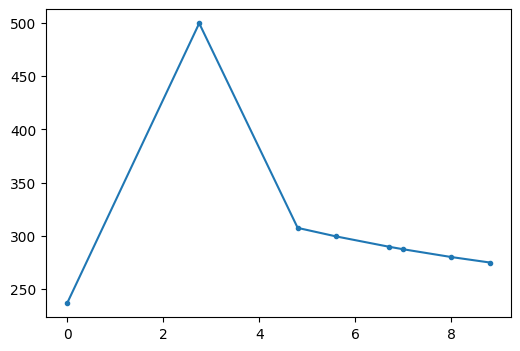

In [217]:
# I'm sure there is a more efficient way to do it, but for now, just use brute force to create the 4D dataset
do_interp = True
[ncol, nrow, nslice, ntime] = image_dim[:-1] + [120, len(time_points)]
st_spgr = np.zeros( ( image_dim[:-1] + [nslice, len(time_points)] ) )
nlabel = len(regions)
# Parameters of Rician noise
v = 8
s = 5


for idx, tp in enumerate(time_points):
    img_aux = np.zeros(image_dim[:-1])
    for regionID, regionData in regions.items():
        # convert the points from mm to pixels:
        ab = [int(XYmm/XYres) for XYmm, XYres in zip(regionData['ab'], image_res[:-1])]
        cd = [int(XYmm/XYres) for XYmm, XYres in zip(regionData['cd'], image_res[:-1])]
        if do_interp:
            stp_spgr = np.interp(tp, time_axis, regionData['st_curve'])
        else:
            stp_spgr = regionData['st_curve'][idx]
        cv2.rectangle(img_aux,
                      ab,cd,
                      stp_spgr,-1)
    # Add Rician Noise
    noise = np.random.normal(scale=s, size=(np.prod(img_aux.shape), 2)) + [[v,0]]
    noise = np.linalg.norm(noise, axis=1)
    fov_noise = 0.*np.median(img_aux)*noise.reshape(image_dim[:-1])*(img_aux > 0.0)
    outer_noise = 0.0*noise.reshape(image_dim[:-1])*(img_aux <= 0.0)
    
    st_spgr[:,:,0,idx] = np.squeeze(img_aux) + fov_noise + outer_noise

envelope = np.hanning(nslice)
st_z0 = st_spgr[:,:,0,:].copy()
for idx in range(nslice):
    st_spgr[:,:,idx,:] = st_z0*envelope[idx]/np.max(envelope)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6.0, 4.0))
ax.plot(time_points, st_z0[120, 370, :] - 0.0*st_z0[120, 370, 0], '.-')
plt.show()


# Create the output as DICOM sequence
To create the output as a dicom sequence, I take one of the dicom headers from the study as a sample and use pydicom's [```codify```](https://pydicom.github.io/pydicom/stable/guides/cli/cli_guide.html#cli-codify) tool to create the code that will define the dicom metadata for each slice (remember that dicom data only process slices, the metadata tells us how to organise it when 3D and 4D).

The code sample ```create_dicom.py``` was created via CLI:

``` bash
user_prompt % pydicom codify sample_DICOM_EilB-preTreatment.dcm > create_dicom.py
```

I created my own UID by requesting it to [Medical Connections](https://www.medicalconnections.co.uk/FreeUID/)

So, let's see how it goes...


In [218]:
# save the output as nifti analyze (later on will create a dicom)
HOMEPATH = os.getenv('HOME')
DATAPATH = os.path.join(HOMEPATH, 'Data', 'QIBA_DRO', 'samples')

today = datetime.datetime.now().strftime('%Y%m%dT%H%M')

OUTPUTNAME = f'nii_test_{today}.nii.gz'
# nifti_img = nib.Nifti1Image(st_spgr, affine=np.eye(4))
# nib.save(nifti_img, os.path.join(DATAPATH, OUTPUTNAME))

# Load my unique UID (created via https://www.medicalconnections.co.uk/FreeUID/)
uid_filename = 'isandexUID.json'
with open(os.path.join(DATAPATH, uid_filename), 'r') as uid_file:
    uid_json = json.loads(uid_file.read())

uid_code = uid_json['UID']
uid_machine = uid_json['machineID']

# Create the user defined dictionary to update the corresponding fields in the dicom header:
dicom_user_metadata = {'file_metadata': FileMetaDataset(),
                       'dataset_metadata': Dataset(),
}
dicom_user_metadata['file_metadata'].MediaStorageSOPInstanceUID = '.'.join([uid_code, uid_machine])
dicom_user_metadata['dataset_metadata'].SOPInstanceUID = '.'.join([uid_code, uid_machine])
dicom_user_metadata['dataset_metadata'].InstanceCreatorUID = uid_code

# last two numbers of StudyInstanceUID are randomly generated and then incremented in 1 for each slice and timepoint:
uid_study_instance_UID = np.random.randint(100,1000, size=2)

dicom_user_metadata['dataset_metadata'].StudyInstanceUID = '.'.join([uid_code, uid_machine,'.'.join(uid_study_instance_UID.astype(str))])
dicom_user_metadata['dataset_metadata'].SeriesInstanceUID = '.'.join([uid_code, uid_machine,'.'.join((uid_study_instance_UID + [0, 1]).astype(str))])
dicom_user_metadata['dataset_metadata'].FrameOfReferenceUID = '.'.join([uid_code, uid_machine,'.'.join((uid_study_instance_UID + [0, 2]).astype(str))])
dicom_user_metadata['dataset_metadata'].StudyID = 'ISANDEX_DRO001'
dicom_user_metadata['dataset_metadata'].SeriesNumber = 800
dicom_user_metadata['dataset_metadata'].AcquisitionNumber = 1

# Image orientation is centred around the origin:
dicom_user_metadata['dataset_metadata'].ImagePositionPatient = [-0.5*imdim*imres for imdim, imres in zip(image_dim, image_res)]

# Create dataset metadata:
InstanceCreationDateTime = datetime.datetime.now()
InstanceCreationDate = InstanceCreationDateTime.strftime('%Y%m%d')
InstanceCreationTime = InstanceCreationDateTime.strftime('%H%M%S.%f')[:-4] # Thanks, ChatGPT, for the [:-4] tip!!
DRO_Birthdate = datetime.datetime.strptime("2000/01/02","%Y/%m/%d")

DRO_Age = InstanceCreationDateTime.year - DRO_Birthdate.year 
if (InstanceCreationDateTime.month, InstanceCreationDateTime.day) < (DRO_Birthdate.month, DRO_Birthdate.day):
    DRO_Age -= 1

dicom_user_metadata['dataset_metadata'].InstanceCreationDate = InstanceCreationDate
dicom_user_metadata['dataset_metadata'].StudyDate = InstanceCreationDate
dicom_user_metadata['dataset_metadata'].SeriesDate = InstanceCreationDate
dicom_user_metadata['dataset_metadata'].AcquisitionDate = InstanceCreationDate
dicom_user_metadata['dataset_metadata'].ContentDate = InstanceCreationDate

dicom_user_metadata['dataset_metadata'].StudyTime = InstanceCreationTime
dicom_user_metadata['dataset_metadata'].SeriesTime = InstanceCreationTime

dicom_user_metadata['dataset_metadata'].Manufacturer = 'ISANDEX'
dicom_user_metadata['dataset_metadata'].StudyDescription = 'Digital Phantom Construction'
dicom_user_metadata['dataset_metadata'].SeriesDescription = 'Digital DCEMRI Breast Phantom'
dicom_user_metadata['dataset_metadata'].ManufacturerModelName = 'ISANDEX DRO v1.0'

dicom_user_metadata['dataset_metadata'].PatientName = 'ISANDEX DRO BREAST'
dicom_user_metadata['dataset_metadata'].PatientID = 'ISANDEX_DRO_V1.0'
dicom_user_metadata['dataset_metadata'].PatientBirthDate = '20000101'
dicom_user_metadata['dataset_metadata'].PatientSex = 'O'
dicom_user_metadata['dataset_metadata'].PatientAge = f'{DRO_Age:03.0f}Y'
dicom_user_metadata['dataset_metadata'].PatientWeight = 45.0
dicom_user_metadata['dataset_metadata'].PregnancyStatus = 1
dicom_user_metadata['dataset_metadata'].PatientIdentityRemoved = 'YES'

dicom_user_metadata['dataset_metadata'].SliceThickness = image_res[-1]* image_pars['pSL'] # '3.0' Overlap 1/pSL slice width (see SpacingBetween)
dicom_user_metadata['dataset_metadata'].RepetitionTime = image_pars['TR']
dicom_user_metadata['dataset_metadata'].EchoTime = image_pars['TE']
dicom_user_metadata['dataset_metadata'].SpacingBetweenSlices = image_res[-1] # '1.5'
# dicom_user_metadata['dataset_metadata'].NumberOfPhaseEncodingSteps = '359'
# dicom_user_metadata['dataset_metadata'].ReconstructionDiameter = '359.0'
# dicom_user_metadata['dataset_metadata'].AcquisitionMatrix = [0, 359, 359, 0]
dicom_user_metadata['dataset_metadata'].EchoTrainLength = image_pars['ETL']
dicom_user_metadata['dataset_metadata'].PercentSampling = image_pars['pPE']
dicom_user_metadata['dataset_metadata'].PercentPhaseFieldOfView = image_pars['pFOV']
# dicom_user_metadata['dataset_metadata'].PixelBandwidth = '433.0'
# dicom_user_metadata['dataset_metadata'].ReceiveCoilName = 'SENSE_BREAST_7M_'
# dicom_user_metadata['dataset_metadata'].DeviceSerialNumber = '0'


dicom_user_metadata['dataset_metadata'].SoftwareVersions = ['1.0.0']
dicom_user_metadata['dataset_metadata'].ProtocolName = 'ISANDEX DRO BREAST DCEMRI'
# dicom_user_metadata['dataset_metadata'].TriggerTime = '0.0'
# dicom_user_metadata['dataset_metadata'].LowRRValue = '0'
# dicom_user_metadata['dataset_metadata'].HighRRValue = '0'
# dicom_user_metadata['dataset_metadata'].IntervalsAcquired = '0'
# dicom_user_metadata['dataset_metadata'].IntervalsRejected = '0'
# dicom_user_metadata['dataset_metadata'].HeartRate = '0'
dicom_user_metadata['dataset_metadata'].InPlanePhaseEncodingDirection = 'ROW'
dicom_user_metadata['dataset_metadata'].FlipAngle = image_pars['FA'] # '10.0'
dicom_user_metadata['dataset_metadata'].SAR = 0.22448302805423 # Sample values from another study
dicom_user_metadata['dataset_metadata'].dBdt = 56.1810722351074# Sample values from another study
dicom_user_metadata['dataset_metadata'].B1rms = 1.089730978012085 # Sample values from another study
dicom_user_metadata['dataset_metadata'].PatientPosition = 'FFP' # Sample values from another study

Tacq = 64.85399627685547 # Sample values from another study
phTime = image_pars['ETL'] * image_pars['TR']
imgTime = phTime * ( nrow * image_pars['pPE'] / 100 ) * ( ( 200 - image_pars['pFOV'] ) / 100 )
volTime = imgTime * nslice / image_pars['pSL']
Tacq = volTime / ( 1000 * 60 ) # Acquisition time of 1 volume in seconds
dicom_user_metadata['dataset_metadata'].AcquisitionDuration = Tacq 
print(f'Tacq: {Tacq}s')

# Image Parameters
dicom_user_metadata['dataset_metadata'].SamplesPerPixel = 1
dicom_user_metadata['dataset_metadata'].PhotometricInterpretation = 'MONOCHROME2'
dicom_user_metadata['dataset_metadata'].Rows = nrow # 528
dicom_user_metadata['dataset_metadata'].Columns = ncol # 528
dicom_user_metadata['dataset_metadata'].PixelSpacing = image_res[:-1] # [0.67961162328720, 0.67961162328720]
dicom_user_metadata['dataset_metadata'].BitsAllocated = image_pars['nBits']
dicom_user_metadata['dataset_metadata'].BitsStored = image_pars['nBits']
dicom_user_metadata['dataset_metadata'].HighBit = image_pars['nBits']-1
dicom_user_metadata['dataset_metadata'].PixelRepresentation = 0

# Just keep things simple, so set the scaling to unchange the pixels (i.e. normalise=False)
normalise = False
rawImg = st_spgr.copy()
nbits = image_pars['nBits']
uintScale = 2**nbits - 1
minMax = [np.min(st_spgr), np.max(st_spgr)]
DeltaImg = np.diff(minMax)[0]
if normalise:
    # normalise the image to [0; 1] and then to [0; 2^nbit - 1]
    rawImg -= minMax[0] 
    rawImg /= DeltaImg
    rawImg *= uintScale
    RescaleSlope = DeltaImg / uintScale
    RescaleIntercept = minMax[0]
else:
    RescaleSlope = 1.0 
    RescaleIntercept = 0.0 
    
dicom_user_metadata['dataset_metadata'].RescaleIntercept = RescaleIntercept
dicom_user_metadata['dataset_metadata'].RescaleSlope = RescaleSlope
dicom_user_metadata['dataset_metadata'].RescaleType = 'normalized'

dicom_user_metadata['dataset_metadata'].RequestedProcedureDescription = 'ISANDEX DIGITAL PHANTOM' # 'MRI Trial Imaging with Contrast'
dicom_user_metadata['dataset_metadata'].RequestedContrastAgent = ''
dicom_user_metadata['dataset_metadata'].StudyComments = ''
dicom_user_metadata['dataset_metadata'].SpecialNeeds = ''
dicom_user_metadata['dataset_metadata'].PatientState = ''
dicom_user_metadata['dataset_metadata'].ScheduledPerformingPhysicianName = ''
dicom_user_metadata['dataset_metadata'].PerformedStationAETitle = 'MRSIM'
dicom_user_metadata['dataset_metadata'].PerformedStationName = ''
dicom_user_metadata['dataset_metadata'].PerformedLocation = ''

# End dataset metadata:
InstanceEndProcedureDateTime = datetime.datetime.now()
InstanceEndProcedureDate = InstanceEndProcedureDateTime.strftime('%Y%m%d')
InstanceEndProcedureTime = InstanceEndProcedureDateTime.strftime('%H%M%S.%f')[:-4] # Thanks, ChatGPT, for the [:-4] tip!!

dicom_user_metadata['dataset_metadata'].PerformedProcedureStepEndDate = InstanceEndProcedureDate # '20230621'
dicom_user_metadata['dataset_metadata'].PerformedProcedureStepEndTime = InstanceEndProcedureTime # '101805'
dicom_user_metadata['dataset_metadata'].PerformedProcedureStepStatus = ''
dicom_user_metadata['dataset_metadata'].PerformedProcedureTypeDescription = ''

# Ensuring the SOPInstanceUID attributes changes for each image was key to make it readable as a sequence in Slicer3D
instanceUID = uid_study_instance_UID + [0, 3]
for tind, ti in enumerate(time_points):
    CurrrentTime = datetime.datetime.now()

    AcquisitionDateTime = InstanceCreationDateTime + datetime.timedelta(0, tind*Tacq)

    AcquisitionDate = AcquisitionDateTime.strftime('%Y%m%d')
    AcquisitionTime = AcquisitionDateTime.strftime('%H%M%S.%f')[:-4]
    dicom_user_metadata['dataset_metadata'].TriggerTime = f'{tind*Tacq*1000:.2f}'
    for slice_nro in range(nslice):
        nacq = slice_nro + tind * nslice
        zpos =  ( slice_nro - ( (nslice - 1.0) / 2.0 ) ) * image_res[-1]
        dicom_user_metadata['dataset_metadata'].InstanceCreationTime = (CurrrentTime + datetime.timedelta(0, tind*Tacq)).strftime('%H%M%S.%f')[:-4]# f'{AcquisitionTime}' # InstanceCreationTime
        
        dicom_user_metadata['dataset_metadata'].AcquisitionTime = AcquisitionTime # '105057.46' # This changes for every timepoint
        dicom_user_metadata['dataset_metadata'].ContentTime = AcquisitionTime    # '105057.46' # This is the same as the AcquisitionTime, I think...

        dicom_user_metadata['dataset_metadata'].InstanceNumber = nacq+1
        # Ensuring the SOPInstanceUID attributes changes for each image was key to make it readable as a sequence in Slicer3D
        dicom_user_metadata['dataset_metadata'].SOPInstanceUID = '.'.join([uid_code, uid_machine, '.'.join(instanceUID.astype(str))])
        instanceUID += [1, 1]

        dicom_user_metadata['dataset_metadata'].ImagePositionPatient[-1] = zpos
        dicom_user_metadata['dataset_metadata'].ImageOrientationPatient = [1, 0, 0, 0, 1, 0]
        dicom_user_metadata['dataset_metadata'].Laterality = ''
        dicom_user_metadata['dataset_metadata'].TemporalPositionIdentifier = f'{tind+1}'
        dicom_user_metadata['dataset_metadata'].NumberOfTemporalPositions = f'{len(time_points)}'
        dicom_user_metadata['dataset_metadata'].PositionReferenceIndicator = ''
        dicom_user_metadata['dataset_metadata'].SliceLocation = f'{zpos}' # '0.0' # '-57.847473144531'
        
        img16 = rawImg[:,:,slice_nro,tind]
        img16 = np.uint16(img16)
        dicom_user_metadata['dataset_metadata'].PixelData = img16.tobytes()

        minMax = [np.min(img16), np.max(img16)]
        DeltaImg = np.diff(minMax)[0]

        # This is just for display purposes, it sets which values are going to be set to 0 in the display
        dicom_user_metadata['dataset_metadata'].WindowCenter = np.mean(minMax) # '1214.0'
        dicom_user_metadata['dataset_metadata'].WindowWidth = DeltaImg # '2110.0'

        path_to_save = os.path.join(DATAPATH, 'dicom', f'sample_dicom_test_{(nacq+1):04d}.dcm')
        dicom_object = create_dicom_header(dicom_user_metadata)

        dicom_object.save_as(path_to_save, write_like_original=False)


Tacq: 64.576512s


In [ ]:
def replace_default_value(meta_data_struct, updated_structure, debug=False):
    
    for key, val in meta_data_struct.items():
        if key in updated_structure:
            if debug:
                print(f"Attribute {key} will be replaced by the user-defined value:\n {updated_structure[key]}")
            meta_data_struct[key] = updated_structure[key]
    
    return meta_data_struct
            
def create_dicom_header(user_info):
    """
    Args:
        user_info (dictionary): dictionary containing the DICOM parameters for each file to be created. They can be any DICOM attribute as long as it is consistent with the dicom definition
        
    """
    # -*- coding: utf-8 -*-
    # Coded version of DICOM file 'sample_DICOM_EilB-preTreatment.dcm'
    # Produced by pydicom codify utility script
    from pydicom.dataset import Dataset, FileMetaDataset
    from pydicom.sequence import Sequence

    # File meta info default data elements
    file_meta = FileMetaDataset()
    file_meta.FileMetaInformationGroupLength = 190
    file_meta.FileMetaInformationVersion = b'\x00\x01'
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.4'        
    file_meta.MediaStorageSOPInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.303.199'
    file_meta.TransferSyntaxUID = '1.2.840.10008.1.2.1'
    file_meta.ImplementationClassUID = '2.16.840.1.114362.1'
    file_meta.ImplementationVersionName = 'MIM716LB1000'
    
    # if user_info contains some of them, they will be replaced in here:
    file_meta = replace_default_value(file_meta, user_info['file_metadata'])    

    # Main data elements - default values
    ds = Dataset()
    ds.SpecificCharacterSet = 'ISO_IR 100'
    ds.ImageType = ['ORIGINAL', 'PRIMARY', 'M_FFE', 'M', 'FFE']
    ds.InstanceCreationDate = '20230621'
    ds.InstanceCreationTime = '145825.067'
    ds.InstanceCreatorUID = '1.3.46.670589.11.89.5'
    ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
    ds.SOPInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.303.199'
    ds.StudyDate = '20230621'
    ds.SeriesDate = '20230621'
    ds.AcquisitionDate = '20230621'
    ds.ContentDate = '20230621'
    ds.StudyTime = '101805'
    ds.SeriesTime = '105040.07000'
    ds.AcquisitionTime = '105057.46'
    ds.ContentTime = '105057.46'
    ds.AccessionNumber = ''
    ds.Modality = 'MR'
    ds.ConversionType = ''
    ds.Manufacturer = 'Philips'
    ds.InstitutionName = ''
    ds.ReferringPhysicianName = ''
    ds.CodeValue = ''
    ds.CodingSchemeDesignator = ''
    ds.CodeMeaning = ''
    ds.StudyDescription = 'MRI Trial Imaging with Contrast'

    # Procedure Code Sequence
    procedure_code_sequence = Sequence()
    ds.ProcedureCodeSequence = procedure_code_sequence

    # Procedure Code Sequence: Procedure Code 1
    procedure_code1 = Dataset()
    procedure_code_sequence.append(procedure_code1)
    procedure_code1.CodeValue = 'UNDEFINED'
    procedure_code1.CodingSchemeDesignator = 'UNDEFINED'
    procedure_code1.CodingSchemeVersion = 'UNDEFINED'
    procedure_code1.CodeMeaning = 'UNDEFINED'
    procedure_code1.ContextGroupExtensionFlag = 'N'

    ds.SeriesDescription = 'Dyn eTHRIVE'
    ds.ManufacturerModelName = 'Ingenia Ambition X'

    # # Referenced Performed Procedure Step Sequence
    # refd_performed_procedure_step_sequence = Sequence()
    # ds.ReferencedPerformedProcedureStepSequence = refd_performed_procedure_step_sequence

    # # Referenced Performed Procedure Step Sequence: Referenced Performed Procedure Step 1
    # refd_performed_procedure_step1 = Dataset()
    # refd_performed_procedure_step_sequence.append(refd_performed_procedure_step1)
    # refd_performed_procedure_step1.InstanceCreationDate = '20230621'
    # refd_performed_procedure_step1.InstanceCreationTime = '101805.632'
    # refd_performed_procedure_step1.InstanceCreatorUID = ds['InstanceCreatorUID']  # '1.3.46.670589.11.89.5'
    # refd_performed_procedure_step1.ReferencedSOPClassUID = '1.2.840.10008.3.1.2.3.3'
    # refd_performed_procedure_step1.ReferencedSOPInstanceUID = ds['SOPInstanceUID']  #'2.16.840.1.114362.1.12081536.24564705482.663432844.277.175'
    # refd_performed_procedure_step1.InstanceNumber = '0'

    # # Referenced Image Sequence
    # refd_image_sequence = Sequence()
    # ds.ReferencedImageSequence = refd_image_sequence

    # # Referenced Image Sequence: Referenced Image 1
    # refd_image1 = Dataset()
    # refd_image_sequence.append(refd_image1)
    # refd_image1.ReferencedSOPClassUID = ds['SOPClassUID']  # '1.2.840.10008.5.1.4.1.1.4'

    # refd_image1.ReferencedSOPInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.277.176' # Correlative to refd_performed_procedure_step1.ReferenceSOPInstanceUID?

    # # Referenced Image Sequence: Referenced Image 2
    # refd_image2 = Dataset()
    # refd_image_sequence.append(refd_image2)
    # refd_image2.ReferencedSOPClassUID = ds['SOPClassUID']  # '1.2.840.10008.5.1.4.1.1.4'
    # refd_image2.ReferencedSOPInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.277.177'# Correlative to refd_performed_procedure_step1.ReferenceSOPInstanceUID?

    # # Referenced Image Sequence: Referenced Image 3
    # refd_image3 = Dataset()
    # refd_image_sequence.append(refd_image3)
    # refd_image3.ReferencedSOPClassUID = ds['SOPClassUID']  # '1.2.840.10008.5.1.4.1.1.4'
    # refd_image3.ReferencedSOPInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.277.177'# Correlative to refd_performed_procedure_step1.ReferenceSOPInstanceUID?

    ds.PatientName = 'EilB Pre TREATMENT'
    ds.PatientID = 'ANON98269'
    ds.PatientBirthDate = ''
    ds.PatientSex = 'F'
    ds.PatientAge = '081Y'
    ds.PatientWeight = '48.0'
    ds.MedicalAlerts = ''
    ds.Allergies = ''
    ds.EthnicGroup = ''
    ds.PregnancyStatus = 1
    ds.PatientIdentityRemoved = 'YES'
    ds.DeidentificationMethod = 'Limited Data Set: MIM.7.1.6.LB10-00'
    ds.ContrastBolusAgent = ''
    ds.BodyPartExamined = 'PHANTOM'
    ds.ScanningSequence = 'GR'
    ds.SequenceVariant = 'SP'
    ds.ScanOptions = 'FS'
    ds.MRAcquisitionType = '3D'
    ds.SliceThickness = '3.0'
    ds.RepetitionTime = '5.19999980926513'
    ds.EchoTime = '2.501'
    ds.NumberOfAverages = '1.0'
    ds.ImagingFrequency = '63.882648'
    ds.ImagedNucleus = '1H'
    ds.EchoNumbers = '1'
    ds.MagneticFieldStrength = '1.5'
    ds.SpacingBetweenSlices = '1.5'
    ds.NumberOfPhaseEncodingSteps = '359'
    ds.EchoTrainLength = '42'
    ds.PercentSampling = '78.5398178100586'
    ds.PercentPhaseFieldOfView = '128.155343191964'
    ds.PixelBandwidth = '433.0'
    ds.DeviceSerialNumber = '0'
    ds.SecondaryCaptureDeviceID = ''
    ds.SecondaryCaptureDeviceManufacturer = ''
    ds.SecondaryCaptureDeviceManufacturerModelName = ''
    ds.SecondaryCaptureDeviceSoftwareVersions = ''
    ds.SoftwareVersions = ['5.7.1', '5.7.1.3']
    ds.VideoImageFormatAcquired = ''
    ds.DigitalImageFormatAcquired = ''
    ds.ProtocolName = 'Dyn eTHRIVE'
    ds.TriggerTime = '0.0'
    ds.LowRRValue = '0'
    ds.HighRRValue = '0'
    ds.IntervalsAcquired = '0'
    ds.IntervalsRejected = '0'
    ds.HeartRate = '0'
    ds.ReconstructionDiameter = '359.0'
    ds.ReceiveCoilName = 'SENSE_BREAST_7M_'
    ds.AcquisitionMatrix = [0, 359, 359, 0]
    ds.InPlanePhaseEncodingDirection = 'ROW'
    ds.FlipAngle = '10.0'
    ds.SAR = '0.22448302805423'
    ds.dBdt = '56.1810722351074'
    ds.B1rms = 1.089730978012085
    ds.PatientPosition = 'FFP'
    ds.AcquisitionDuration = 64.85399627685547
    ds.DiffusionBValue = 0.0
    ds.DiffusionGradientOrientation = [0.0, 0.0, 0.0]
    ds.StudyInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.273.172'
    ds.SeriesInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.273.173'
    ds.StudyID = 'ANON18218'
    ds.SeriesNumber = '501'
    ds.AcquisitionNumber = '5'
    ds.InstanceNumber = '493'
    ds.ImagePositionPatient = [-168.43985679745, -143.33447197079, 57.8474731445313]
    ds.ImageOrientationPatient = [1, 0, 0, 0, 1, 0]
    ds.FrameOfReferenceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.273.174'
    ds.Laterality = ''
    ds.TemporalPositionIdentifier = '1'
    ds.NumberOfTemporalPositions = '6'
    ds.PositionReferenceIndicator = ''
    ds.SliceLocation = '-57.847473144531'
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = 'MONOCHROME2'
    ds.Rows = 528
    ds.Columns = 528
    ds.PixelSpacing = [0.67961162328720, 0.67961162328720]
    ds.BitsAllocated = 16
    ds.BitsStored = 12
    ds.HighBit = 11
    ds.PixelRepresentation = 0
    ds.WindowCenter = '1214.0'
    ds.WindowWidth = '2110.0'
    ds.RescaleIntercept = '0.0'
    ds.RescaleSlope = '11.0383394383394'
    ds.RescaleType = 'normalized'
    ds.RequestedProcedureDescription = 'MRI Trial Imaging with Contrast'
    ds.RequestedContrastAgent = ''
    ds.StudyComments = ''
    ds.SpecialNeeds = ''
    ds.PatientState = ''
    ds.ScheduledPerformingPhysicianName = ''
    ds.PerformedStationAETitle = 'MRSIM'
    ds.PerformedStationName = ''
    ds.PerformedLocation = ''
    ds.PerformedProcedureStepEndDate = '20230621'
    ds.PerformedProcedureStepEndTime = '101805'
    ds.PerformedProcedureStepStatus = ''
    ds.PerformedProcedureTypeDescription = ''

    # # Performed Protocol Code Sequence
    # performed_protocol_code_sequence = Sequence()
    # ds.PerformedProtocolCodeSequence = performed_protocol_code_sequence

    # # Performed Protocol Code Sequence: Performed Protocol Code 1
    # performed_protocol_code1 = Dataset()
    # performed_protocol_code_sequence.append(performed_protocol_code1)
    # performed_protocol_code1.CodeValue = 'UNDEFINED'
    # performed_protocol_code1.CodingSchemeDesignator = 'UNDEFINED'
    # performed_protocol_code1.CodingSchemeVersion = 'UNDEFINED'
    # performed_protocol_code1.CodeMeaning = 'UNDEFINED'
    # performed_protocol_code1.ContextGroupExtensionFlag = 'N'


    # # Request Attributes Sequence
    # request_attributes_sequence = Sequence()
    # ds.RequestAttributesSequence = request_attributes_sequence

    # # Request Attributes Sequence: Request Attributes 1
    # request_attributes1 = Dataset()
    # request_attributes_sequence.append(request_attributes1)
    # request_attributes1.AccessionNumber = '4513991'
    # request_attributes1.RequestedProcedureDescription = 'MRI Trial Imaging with Contrast'
    # request_attributes1.ScheduledProcedureStepDescription = 'MRI Trial Imaging with Contrast'

    # # Scheduled Protocol Code Sequence
    # scheduled_protocol_code_sequence = Sequence()
    # request_attributes1.ScheduledProtocolCodeSequence = scheduled_protocol_code_sequence

    # # Scheduled Protocol Code Sequence: Scheduled Protocol Code 1
    # scheduled_protocol_code1 = Dataset()
    # scheduled_protocol_code_sequence.append(scheduled_protocol_code1)
    # scheduled_protocol_code1.CodeValue = 'UNDEFINED'
    # scheduled_protocol_code1.CodingSchemeDesignator = 'UNDEFINED'
    # scheduled_protocol_code1.CodingSchemeVersion = 'UNDEFINED'
    # scheduled_protocol_code1.CodeMeaning = 'UNDEFINED'
    # scheduled_protocol_code1.ContextGroupExtensionFlag = 'N'

    # request_attributes1.ScheduledProcedureStepID = 'MRTRc'
    # request_attributes1.PreMedication = ''
    # request_attributes1.CommentsOnTheScheduledProcedureStep = ''
    # request_attributes1.RequestedProcedureID = 'MRTRc'

    # ds.RequestedProcedureID = 'MRTRc'
    # ds.ReasonForTheRequestedProcedure = ''
    # ds.RequestedProcedurePriority = ''
    # ds.PatientTransportArrangements = ''
    # ds.RequestedProcedureLocation = ''
    # ds.RequestedProcedureComments = ''
    # ds.ReasonForTheImagingServiceRequest = ''
    # ds.IssueDateOfImagingServiceRequest = '20230621'
    # ds.IssueTimeOfImagingServiceRequest = '101805.616'
    # ds.OrderEntererLocation = ''
    # ds.OrderCallbackPhoneNumber = ''
    # ds.ImagingServiceRequestComments = ''

    # # Real World Value Mapping Sequence
    # real_world_value_mapping_sequence = Sequence()
    # ds.RealWorldValueMappingSequence = real_world_value_mapping_sequence

    # # Real World Value Mapping Sequence: Real World Value Mapping 1
    # real_world_value_mapping1 = Dataset()
    # real_world_value_mapping_sequence.append(real_world_value_mapping1)
    # real_world_value_mapping1.LUTExplanation = 'Real World Value Mapping for normalized'

    # # Measurement Units Code Sequence
    # measurement_units_code_sequence = Sequence()
    # real_world_value_mapping1.MeasurementUnitsCodeSequence = measurement_units_code_sequence

    # # Measurement Units Code Sequence: Measurement Units Code 1
    # measurement_units_code1 = Dataset()
    # measurement_units_code_sequence.append(measurement_units_code1)
    # measurement_units_code1.CodeValue = '1'
    # measurement_units_code1.CodingSchemeDesignator = 'UCUM'
    # measurement_units_code1.CodeMeaning = 'no units'
    # measurement_units_code1.ContextUID = '1.2.840.10008.6.1.918'

    # real_world_value_mapping1.LUTLabel = 'Philips'
    # real_world_value_mapping1.RealWorldValueLastValueMapped = 4095
    # real_world_value_mapping1.RealWorldValueFirstValueMapped = 0
    # real_world_value_mapping1.RealWorldValueIntercept = 0.0
    # real_world_value_mapping1.RealWorldValueSlope = 11.038339438339438

    # ds.PresentationLUTShape = 'IDENTITY'
    ds.PixelData = ''# XXX Array of 557568 bytes excluded

    # if user_info contains some of them, they will be replaced in here:
    ds = replace_default_value(ds, user_info['dataset_metadata'])

    # # After replacing the default values, let's populate the sequence (to check whether this defines a time sequence)
    # # # Referenced Performed Procedure Step Sequence
    # refd_performed_procedure_step_sequence = Sequence()
    # ds.ReferencedPerformedProcedureStepSequence = refd_performed_procedure_step_sequence

    # # # Referenced Performed Procedure Step Sequence: Referenced Performed Procedure Step 1
    # refd_performed_procedure_step1 = Dataset()
    # refd_performed_procedure_step_sequence.append(refd_performed_procedure_step1)
    # refd_performed_procedure_step1.InstanceCreationDate = ds.InstanceCreationDate # '20230621'
    # refd_performed_procedure_step1.InstanceCreationTime = ds.InstanceCreationTime #'101805.632'
    # refd_performed_procedure_step1.InstanceCreatorUID = ds.InstanceCreatorUID  # '1.3.46.670589.11.89.5'
    # refd_performed_procedure_step1.ReferencedSOPClassUID = ds.SOPClassUID #'1.2.840.10008.3.1.2.3.3'
    # refd_performed_procedure_step1.ReferencedSOPInstanceUID = ds.SOPInstanceUID  #'2.16.840.1.114362.1.12081536.24564705482.663432844.277.175'
    # refd_performed_procedure_step1.InstanceNumber = '0'

    # # Referenced Image Sequence
    # refd_image_sequence = Sequence()
    # ds.ReferencedImageSequence = refd_image_sequence

    # # Referenced Image Sequence: Referenced Image 1
    # refd_image1 = Dataset()
    # refd_image_sequence.append(refd_image1)
    # refd_image1.ReferencedSOPClassUID = ds['SOPClassUID']  # '1.2.840.10008.5.1.4.1.1.4'

    # refd_image1.ReferencedSOPInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.277.176' # Correlative to refd_performed_procedure_step1.ReferenceSOPInstanceUID?

    # # Referenced Image Sequence: Referenced Image 2
    # refd_image2 = Dataset()
    # refd_image_sequence.append(refd_image2)
    # refd_image2.ReferencedSOPClassUID = ds['SOPClassUID']  # '1.2.840.10008.5.1.4.1.1.4'
    # refd_image2.ReferencedSOPInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.277.177'# Correlative to refd_performed_procedure_step1.ReferenceSOPInstanceUID?

    # # Referenced Image Sequence: Referenced Image 3
    # refd_image3 = Dataset()
    # refd_image_sequence.append(refd_image3)
    # refd_image3.ReferencedSOPClassUID = ds['SOPClassUID']  # '1.2.840.10008.5.1.4.1.1.4'
    # refd_image3.ReferencedSOPInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.277.177'# Correlative to refd_performed_procedure_step1.ReferenceSOPInstanceUID?

    # 
    ds.file_meta = file_meta
    ds.is_implicit_VR = False
    ds.is_little_endian = True
    
    return ds




# Appendices

## Linearisation of the SPGR equation
By considering $T_E << T_R$, $E_1(T_1, T_R)$ as just $E_1$, and repeating the acquisition for multiples flip angles $\alpha_i$ while keeping everything else constant, specially $T_R$ and $T_E$, the equation [] becomes:
\begin{equation}
S(\alpha_i) = S_i = M_0\sin\alpha_i\frac{1 - E_1}{1 - (\cos\alpha_i)E_1}
\end{equation}
multiplying by $(1 - (\cos\alpha_i)E_1)$:
\begin{equation}
S_i - S_i\cos\alpha_iE_1 = M_0\sin\alpha_i - M_0\sin\alpha_i E_1
\end{equation}
dividing by $\sin\alpha_i$ and reorganising the terms:
\begin{equation}
\frac{S_i}{\sin\alpha_i} - \frac{S_iE_1}{\tan\alpha_i} = M_0 - M_0E_1
\end{equation}
and isolating the signal intensity as a function of $E_1$, we get:
\begin{equation}
\frac{S_i}{\sin\alpha_i} = E_1\frac{S_i}{\tan\alpha_i} + M_0(1 - E_1)
\end{equation}


## Relaxitivy of contrast agents at 1.5T
The following table has been taken from https://s.mriquestions.com/what-is-relaxivity.html and is based on [Rohrer et al. Invest. Radiol 40:715-724; 2005](https://journals.lww.com/investigativeradiology/abstract/2005/11000/comparison_of_magnetic_properties_of_mri_contrast.5.aspx)

Relaxivitiy of plasma blood at $37^{o}$ and 1.5T:

| Brand Name  | $r_1\quad[L\ mmol^{-1} s^{-1}]$ |
| ------------|  :---------------------------:  |
| Magnevist®  | 4.1  |
| MultiHance® | 6.3  |
| Omniscan ™  | 4.3  |
| Dotarem®    | 3.6  |
| ProHance®   | 4.1  |
| Gadavist®   | 5.2  |
| Eovist®     | 6.9  |
| Vueway™     | 12.8 |


## $T_1$ of tissues at 1.5T
The following table has been taken from https://mri-q.com/why-is-t1--t2.html, for breast (fat and glandular tissues), I've used the average reported by [Rakow-Penner et al. JMRI 23(1): 87-91; 2005](https://onlinelibrary.wiley.com/doi/full/10.1002/jmri.20469) and for malingant breast tissue, I've followed the book ["Breast MRI: Fundamentals and Technical Aspects", R.E. Hendriks, 2008](https://link.springer.com/book/10.1007/978-0-387-73507-8), its paper conference ["Breast MRI: Using Physics to Maximize Its Sensitivity and
Specificity to Breast Cancer"](https://www.aapm.org/meetings/04AM/pdf/14-2345-77728.pdf), which cited [Mechant TE et al. Acta Radiologica 34(4):356-361; 1993](https://journals.sagepub.com/doi/10.1177/028418519303400409). Blood relaxation times were taken from [M. Barth and E. Moser. Cell Mol Biol 43(5): 783-791; 1997](https://pubmed.ncbi.nlm.nih.gov/9298600/)

Average $T_1$ values of some tissues at 1.5T

|    Tissue   | $T_1$[ms] | $T_2$[ms] |
| ----------- | :-------: | :-------: |
| Water/CSF   | 4000      | 2000      |
| Gray matter | 900       | 90        | 
| Muscle      | 900       | 50        | 
| Liver       | 500       | 40        | 
| Fat         | 250       | 70        | 
| Tendon      | 400       | 5         | 
| Proteins    | 250       | 0.1- 1.0  | 
| Ice         | 5000      | 0.001     | 
| Fat Tissue (Breast)       | 334   | 53 |
| Glandular Tissue (Breast) | 1201  | 58 |
| Malignant Tissue (Breast) | 876   | 75 |
| Blood (Arterial @23C) | 1434   | 254 |

